In [1]:
import numpy as np
import pandas as pd
import torch
from FXP import FXP
from utils import print_num_params

In [2]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery = np.load('./calcev4/concat_df.npy', allow_pickle=True)
Battery = Battery.item()

rest_time = np.load('./calcev4/global_df.npy', allow_pickle=True)
rest_time = rest_time.item()

window_size=8
prediction_interval=1
multichannel_features = ['voltage','current','resistance']
global_seq_features = ['x5', 'rest_period', 'capacity']
epochs = EPOCH = 1000
BATTERIES = ['CS2_35', 'CS2_36','CS2_37','CS2_38']

In [3]:
df = {}
df['CS2_35'] = pd.DataFrame()
df['CS2_36'] = pd.DataFrame()
df['CS2_37'] = pd.DataFrame()
df['CS2_38'] = pd.DataFrame()

Trainable params: 22440
Trainable params: 22440
Trainable params: 22440
Trainable params: 22440


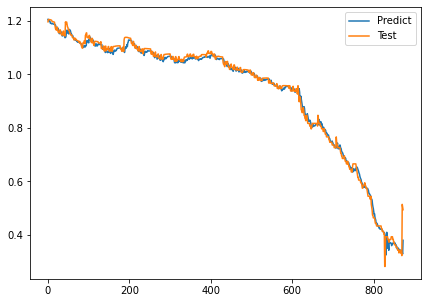

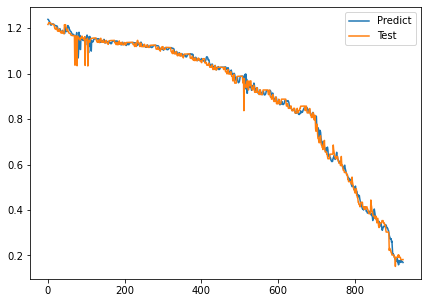

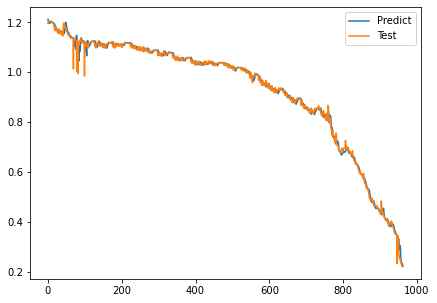

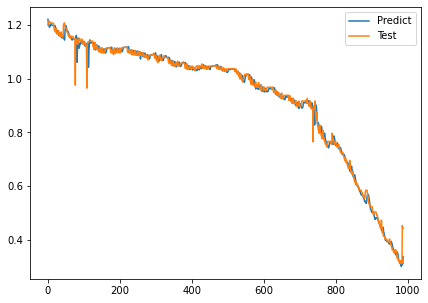

In [4]:
fxp = FXP()
for bat in BATTERIES:
    batteries = BATTERIES.copy()
    batteries.remove(bat)
    batteries = batteries + [bat]

    X_train, Y_train, X_val, Y_val, X_test,Y_test = fxp.cross_validation(batteries, Battery, rest_time, validation=0.1)
    
    model = torch.load('FXP/' + str(batteries[-1]) + '/checkpoint.pt')
    print_num_params(model)

    pred, test = fxp.test(model, X_test, Y_test, out_dir='FXP/' + str(batteries[-1]), pin=str(batteries[-1]))
    
    df[bat]['true'] = test.numpy().flatten()
    
    df[bat]['FPX'] = pred.numpy().flatten()
    

In [5]:
from MC_LSTM import MC_LSTM

mc_lstm = MC_LSTM()

for bat in BATTERIES:
    batteries = BATTERIES.copy()
    batteries.remove(bat)
    batteries = batteries + [bat]

    X_train, Y_train, X_val, Y_val, X_test,Y_test = mc_lstm.cross_validation(batteries, Battery, rest_time, validation=0.1)

    model = mc_lstm.build_model((X_train[0].shape[1:], X_train[1].shape[1:], X_train[2].shape[1:], X_train[3].shape[1:]))

    model.load_weights('MC_LSTM/' + str(batteries[-1]) + '/checkpoint_weight')
    pred, _ = mc_lstm.test(model, X_test, Y_test, out_dir='MC_LSTM/' + str(batteries[-1]), pin=str(batteries[-1]))
    
    df[bat]['MC_LSTM'] = pred.flatten()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Voltage_Input (InputLayer)     [(None, 8, 11)]      0           []                               
                                                                                                  
 Ampere_Input (InputLayer)      [(None, 8, 11)]      0           []                               
                                                                                                  
 Temperature_Input (InputLayer)  [(None, 8, 11)]     0           []                               
                                                                                                  
 Capacity_Input (InputLayer)    [(None, 8, 1)]       0           []                               
                                                                                              

 Output (Dense)                 (None, 1)            85          ['tf.concat_2[0][0]']            
                                                                                                  
Total params: 10,333
Trainable params: 10,333
Non-trainable params: 0
__________________________________________________________________________________________________
None
31/31 [==============================] - 1s 3ms/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Voltage_Input (InputLayer)     [(None, 8, 11)]      0           []                               
                                                                                                  
 Ampere_Input (InputLayer)      [(None, 8, 11)]      0           []                               
                                                               

Trainable params: 15
Trainable params: 15
Trainable params: 15
Trainable params: 15


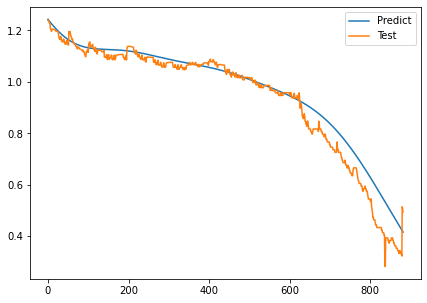

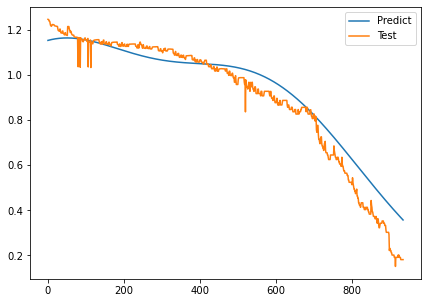

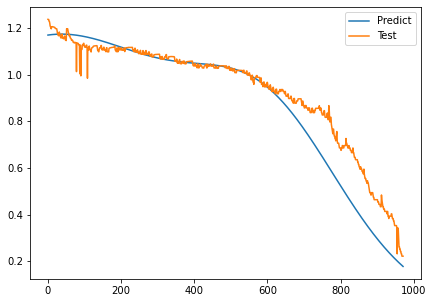

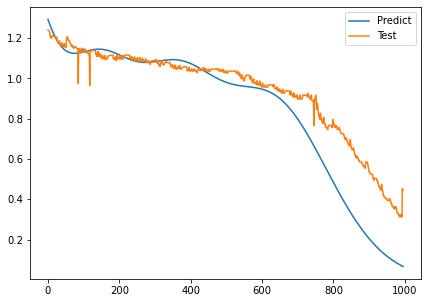

In [6]:
from basic_models import GF,Battery_SVR,MLP,Battery_LSTM

gf = GF()

for bat in BATTERIES:
    batteries = BATTERIES.copy()
    batteries.remove(bat)
    batteries = batteries + [bat]

    X_train, Y_train, X_val, Y_val, X_test,Y_test = gf.cross_validation(batteries, Battery, validation=0.1)

    model = gf.build_model(k=5)
    print_num_params(model)

    model = torch.load('GFv1/' + str(batteries[-1]) + '/checkpoint.pt')

    pred, test = gf.test(model, X_test, Y_test, out_dir='GFv1/' + str(batteries[-1]), pin=str(batteries[-1]))
    
    df[bat]['GF'] = pred.numpy().flatten()[-len(df[bat]):]

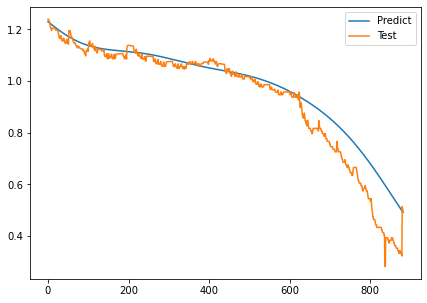

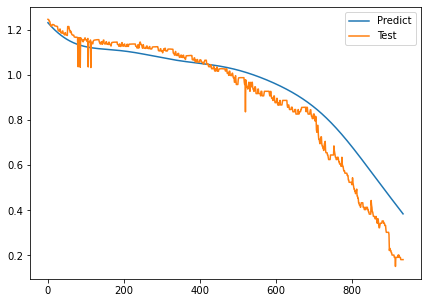

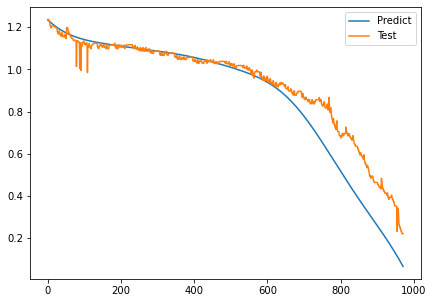

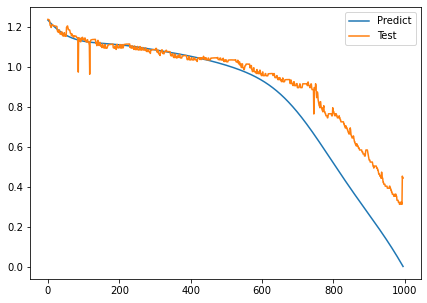

In [7]:
svr = Battery_SVR()

for bat in BATTERIES:
    batteries = BATTERIES.copy()
    batteries.remove(bat)
    batteries = batteries + [bat]

    X_train, Y_train, X_val, Y_val, X_test,Y_test = svr.cross_validation(batteries, Battery, validation=0.1)

    model = svr.load_model('SVR/' + str(batteries[-1]) + '/checkpoint.pkl')

    pred, test = svr.test(model, X_test, Y_test, out_dir='SVR/' + str(batteries[-1]), pin=str(batteries[-1]))

    df[bat]['SVR'] = pred.flatten()[-len(df[bat]):]

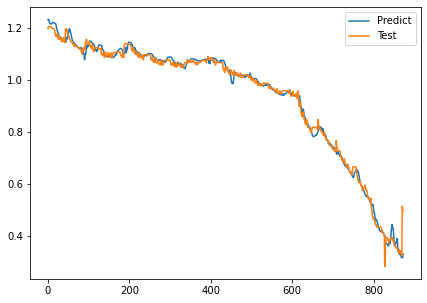

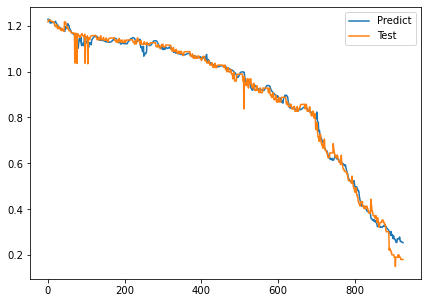

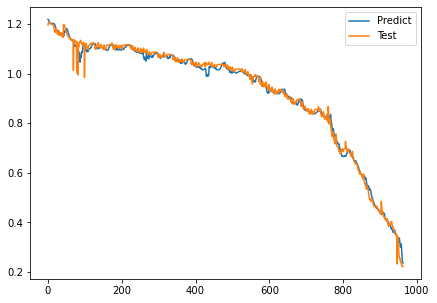

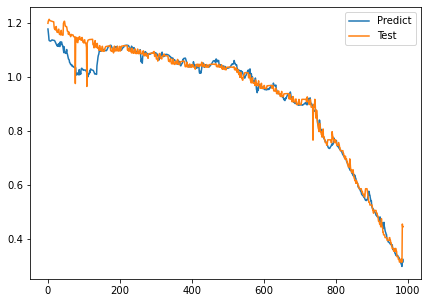

In [8]:
mlp = MLP()

for bat in BATTERIES:
    batteries = BATTERIES.copy()
    batteries.remove(bat)
    batteries = batteries + [bat]

    X_train, Y_train, X_val, Y_val, X_test,Y_test = mlp.cross_validation(batteries, Battery, rest_time, validation=0.1)

    model  = torch.load('MLP/' + str(batteries[-1])+ '/checkpoint.pt')

    pred, test = mlp.test(model, X_test, Y_test, out_dir='MLP/' + str(batteries[-1]), pin=str(batteries[-1]))
    
    df[bat]['MLP'] = pred.numpy().flatten()

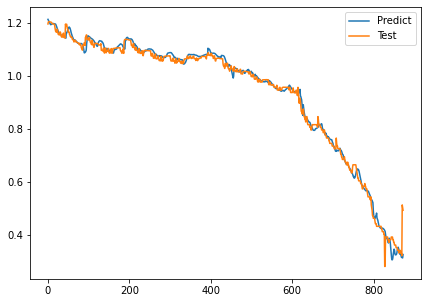

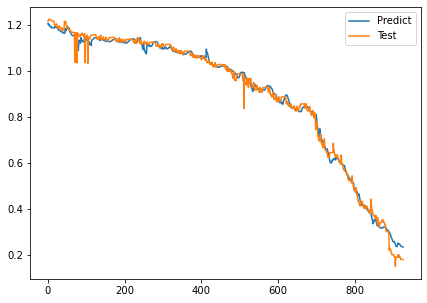

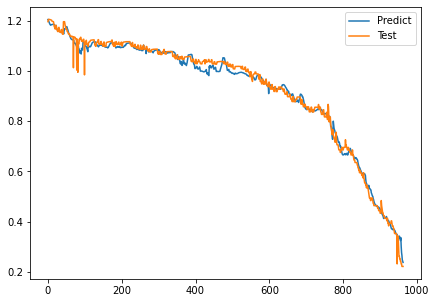

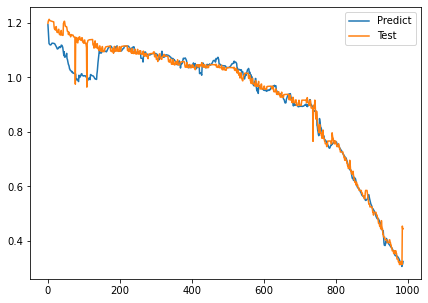

In [9]:
lstm = Battery_LSTM()

for bat in BATTERIES:
    batteries = BATTERIES.copy()
    batteries.remove(bat)
    batteries = batteries + [bat]

    X_train, Y_train, X_val, Y_val, X_test,Y_test = lstm.cross_validation(batteries, Battery, rest_time, validation=0.1)

    model  = torch.load('LSTM/' + str(batteries[-1])+ '/checkpoint.pt')

    pred, test = lstm.test(model, X_test, Y_test, out_dir='LSTM/' + str(batteries[-1]), pin=str(batteries[-1]))
    
    df[bat]['LSTM'] = pred.flatten()

In [10]:
df['CS2_35']

true       FPX   MC_LSTM        GF       SVR       MLP      LSTM
0    1.196341  1.205507  1.206723  1.225451  1.218759  1.230726  1.213760
1    1.204223  1.201637  1.215630  1.223585  1.217517  1.232065  1.210559
2    1.205125  1.200893  1.219573  1.221735  1.216280  1.230218  1.207739
3    1.204976  1.197934  1.218009  1.219901  1.215049  1.224205  1.203699
4    1.204746  1.198678  1.213626  1.218086  1.213823  1.219804  1.200123
..        ...       ...       ...       ...       ...       ...       ...
868  0.332783  0.335752  0.331017  0.426197  0.500716  0.316726  0.316983
869  0.322704  0.331572  0.328931  0.423614  0.498363  0.316263  0.316144
870  0.514302  0.335025  0.329079  0.421036  0.496014  0.316831  0.315356
871  0.504233  0.329133  0.328584  0.418461  0.493668  0.315970  0.314317
872  0.494134  0.380087  0.337273  0.415889  0.491326  0.330776  0.327234

[873 rows x 7 columns]

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

[]

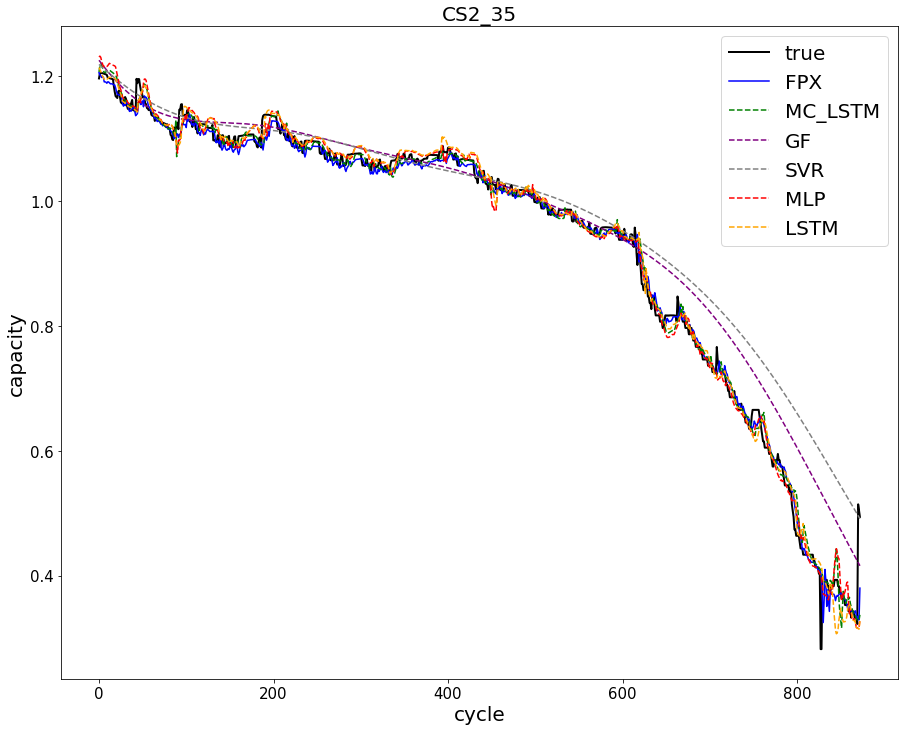

In [14]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in ['CS2_35']:
    sns.lineplot(data=df[bat]['true'],linewidth=2,color='black',ax=ax)
    sns.lineplot(data=df[bat]['FPX'],linewidth=1.5,color='blue',ax=ax)
    sns.lineplot(data=df[bat]['MC_LSTM'],linewidth=1.5,color='g',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['GF'],linewidth=1.5,color='purple',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['SVR'],linewidth=1.5,color='gray',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['MLP'],linewidth=1.5,color='red',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['LSTM'],linewidth=1.5,color='orange',linestyle="--",ax=ax)
    ax.legend(['true','FPX','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax.set_xlabel('cycle',fontsize=20)
    ax.set_ylabel('capacity',fontsize=20)
    ax.set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
# plt.suptitle("Cycle 200-450",fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot()

[]

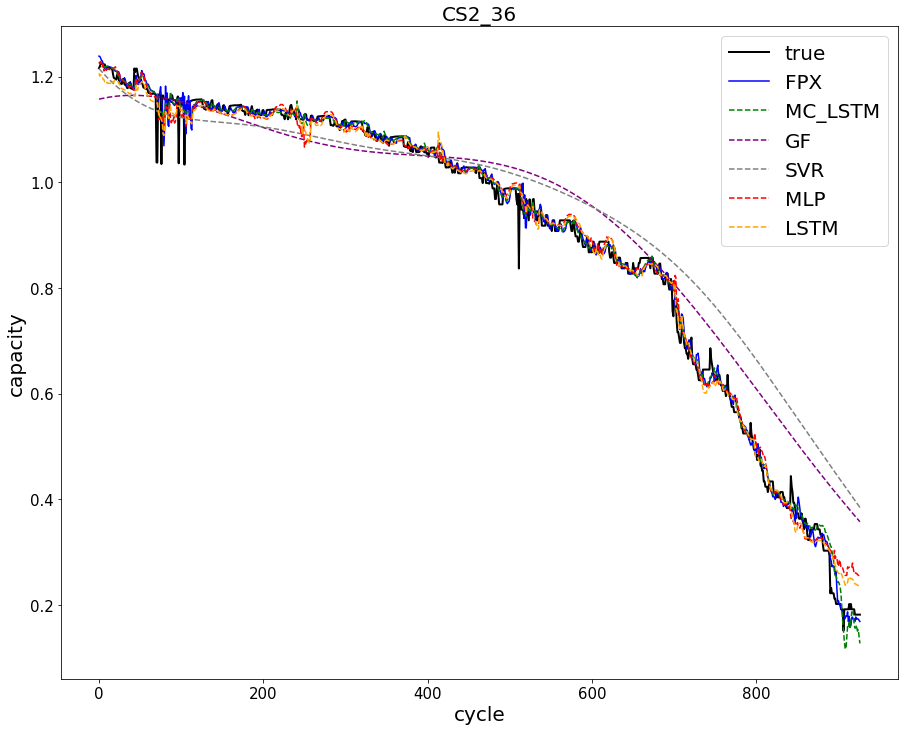

In [17]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in ['CS2_36']:
    sns.lineplot(data=df[bat]['true'],linewidth=2,color='black',ax=ax)
    sns.lineplot(data=df[bat]['FPX'],linewidth=1.5,color='blue',ax=ax)
    sns.lineplot(data=df[bat]['MC_LSTM'],linewidth=1.5,color='g',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['GF'],linewidth=1.5,color='purple',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['SVR'],linewidth=1.5,color='gray',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['MLP'],linewidth=1.5,color='red',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['LSTM'],linewidth=1.5,color='orange',linestyle="--",ax=ax)
    ax.legend(['true','FPX','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax.set_xlabel('cycle',fontsize=20)
    ax.set_ylabel('capacity',fontsize=20)
    ax.set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
# plt.suptitle("Cycle 200-450",fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot()

[]

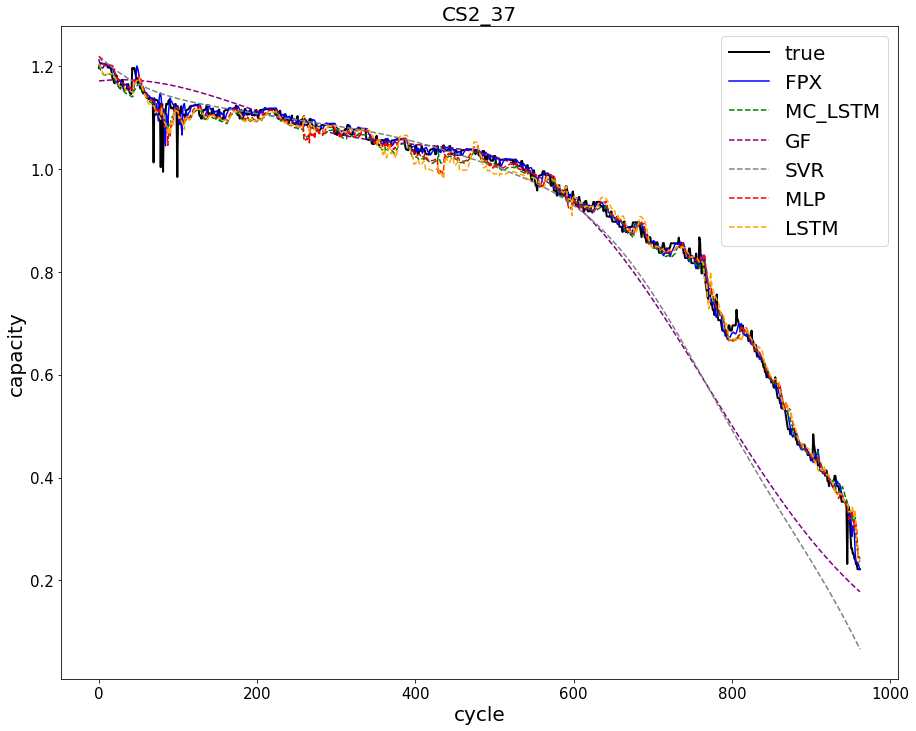

In [18]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in ['CS2_37']:
    sns.lineplot(data=df[bat]['true'],linewidth=2,color='black',ax=ax)
    sns.lineplot(data=df[bat]['FPX'],linewidth=1.5,color='blue',ax=ax)
    sns.lineplot(data=df[bat]['MC_LSTM'],linewidth=1.5,color='g',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['GF'],linewidth=1.5,color='purple',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['SVR'],linewidth=1.5,color='gray',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['MLP'],linewidth=1.5,color='red',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['LSTM'],linewidth=1.5,color='orange',linestyle="--",ax=ax)
    ax.legend(['true','FPX','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax.set_xlabel('cycle',fontsize=20)
    ax.set_ylabel('capacity',fontsize=20)
    ax.set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
# plt.suptitle("Cycle 200-450",fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot()

[]

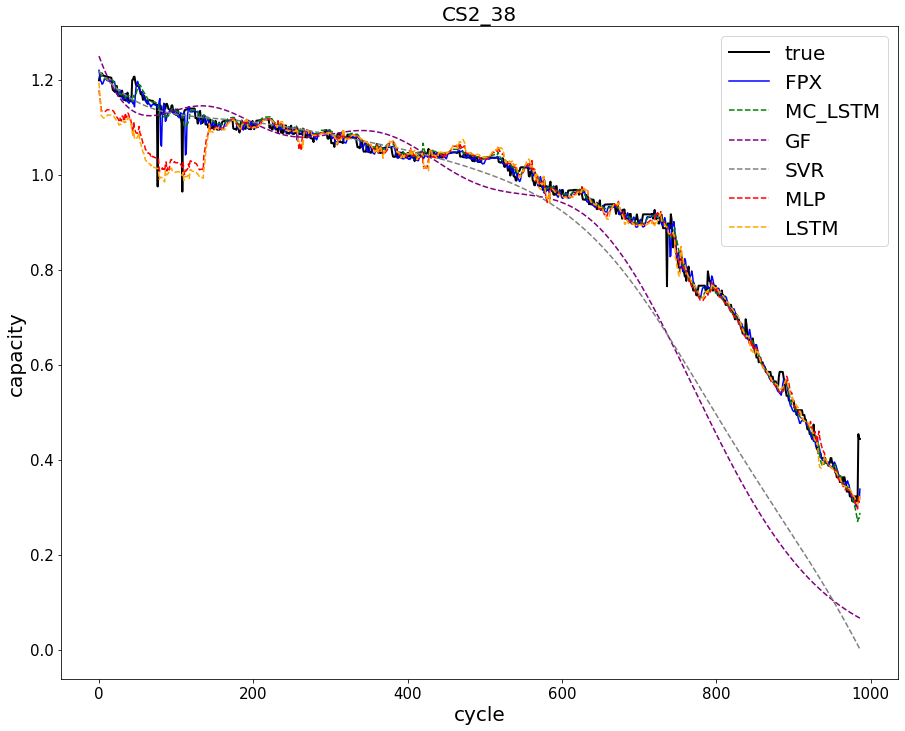

In [25]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in ['CS2_38']:
    sns.lineplot(data=df[bat]['true'],linewidth=2,color='black',ax=ax)
    sns.lineplot(data=df[bat]['FPX'],linewidth=1.5,color='blue',ax=ax)
    sns.lineplot(data=df[bat]['MC_LSTM'],linewidth=1.5,color='g',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['GF'],linewidth=1.5,color='purple',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['SVR'],linewidth=1.5,color='gray',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['MLP'],linewidth=1.5,color='red',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat]['LSTM'],linewidth=1.5,color='orange',linestyle="--",ax=ax)
    ax.legend(['true','FPX','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax.set_xlabel('cycle',fontsize=20)
    ax.set_ylabel('capacity',fontsize=20)
    ax.set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
# plt.suptitle("Cycle 200-450",fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot()

[]

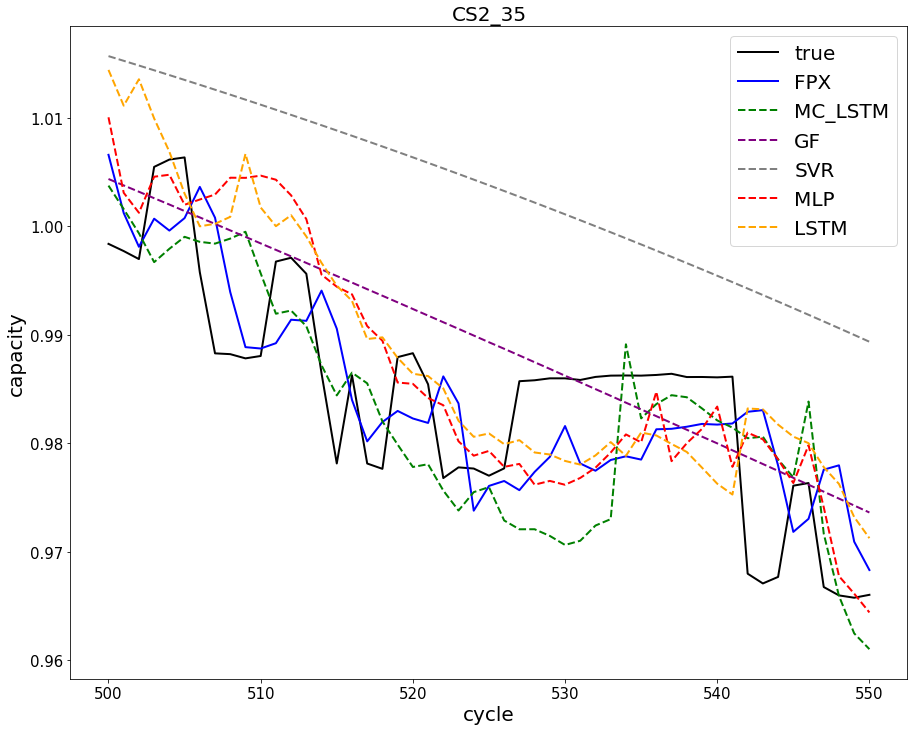

In [21]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in ['CS2_35']:
    sns.lineplot(data=df[bat].loc[500:550,'true'],linewidth=2,color='black',ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'FPX'],linewidth=2,color='blue',ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'MC_LSTM'],linewidth=2,color='g',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'GF'],linewidth=2,color='purple',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'SVR'],linewidth=2,color='gray',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'MLP'],linewidth=2,color='red',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'LSTM'],linewidth=2,color='orange',linestyle="--",ax=ax)
    ax.legend(['true','FPX','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax.set_xlabel('cycle',fontsize=20)
    ax.set_ylabel('capacity',fontsize=20)
    ax.set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
# plt.suptitle("Cycle 200-450",fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot()

[]

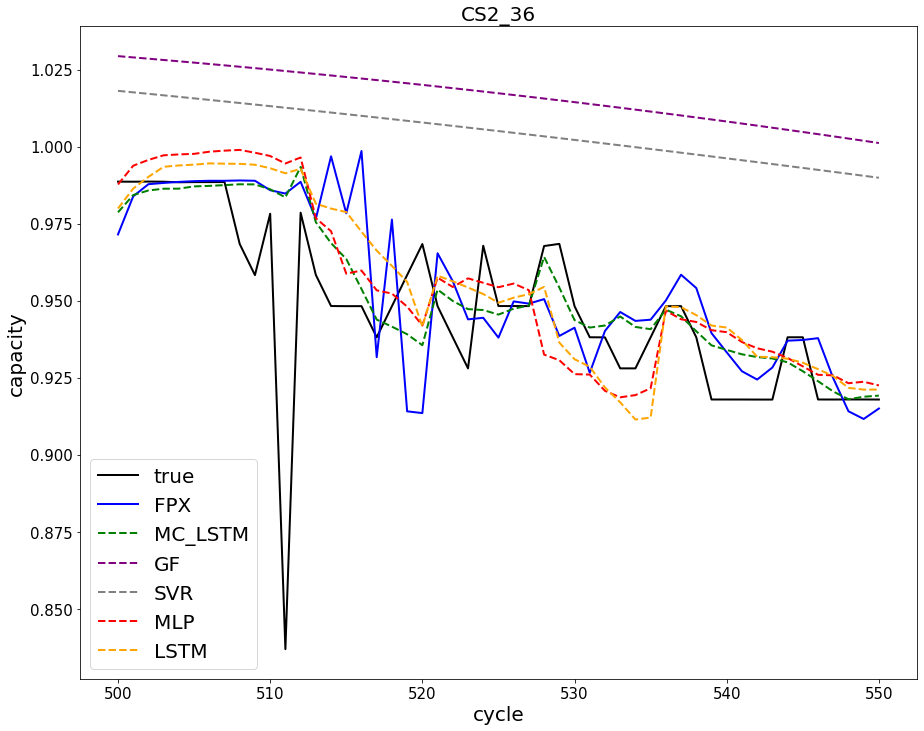

In [22]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in ['CS2_36']:
    sns.lineplot(data=df[bat].loc[500:550,'true'],linewidth=2,color='black',ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'FPX'],linewidth=2,color='blue',ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'MC_LSTM'],linewidth=2,color='g',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'GF'],linewidth=2,color='purple',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'SVR'],linewidth=2,color='gray',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'MLP'],linewidth=2,color='red',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'LSTM'],linewidth=2,color='orange',linestyle="--",ax=ax)
    ax.legend(['true','FPX','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax.set_xlabel('cycle',fontsize=20)
    ax.set_ylabel('capacity',fontsize=20)
    ax.set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
# plt.suptitle("Cycle 200-450",fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot()

[]

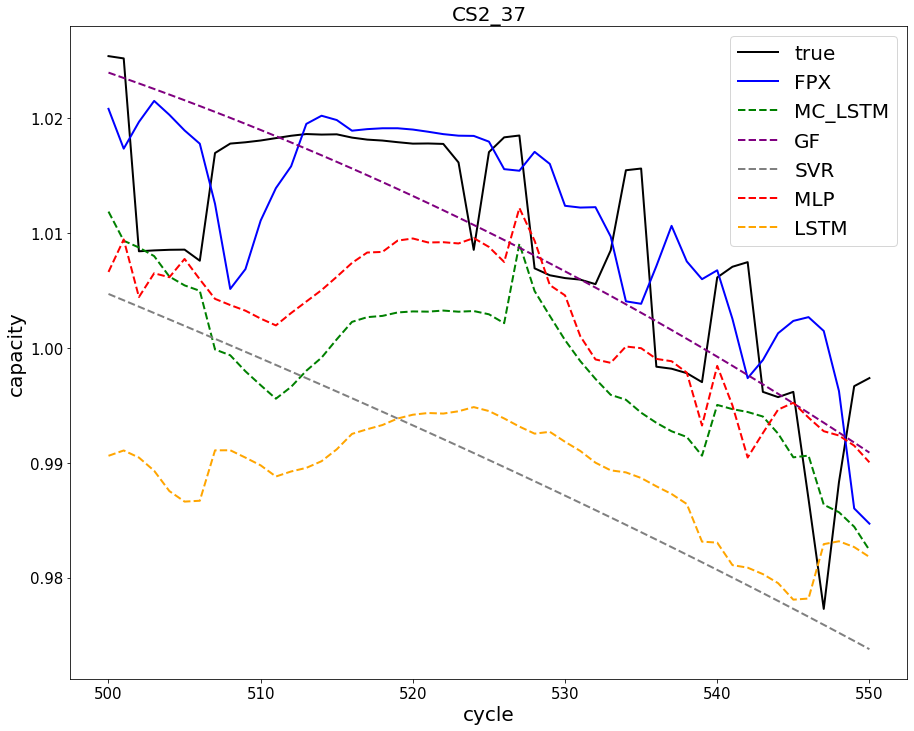

In [23]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in ['CS2_37']:
    sns.lineplot(data=df[bat].loc[500:550,'true'],linewidth=2,color='black',ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'FPX'],linewidth=2,color='blue',ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'MC_LSTM'],linewidth=2,color='g',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'GF'],linewidth=2,color='purple',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'SVR'],linewidth=2,color='gray',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'MLP'],linewidth=2,color='red',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'LSTM'],linewidth=2,color='orange',linestyle="--",ax=ax)
    ax.legend(['true','FPX','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax.set_xlabel('cycle',fontsize=20)
    ax.set_ylabel('capacity',fontsize=20)
    ax.set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
# plt.suptitle("Cycle 200-450",fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot()

[]

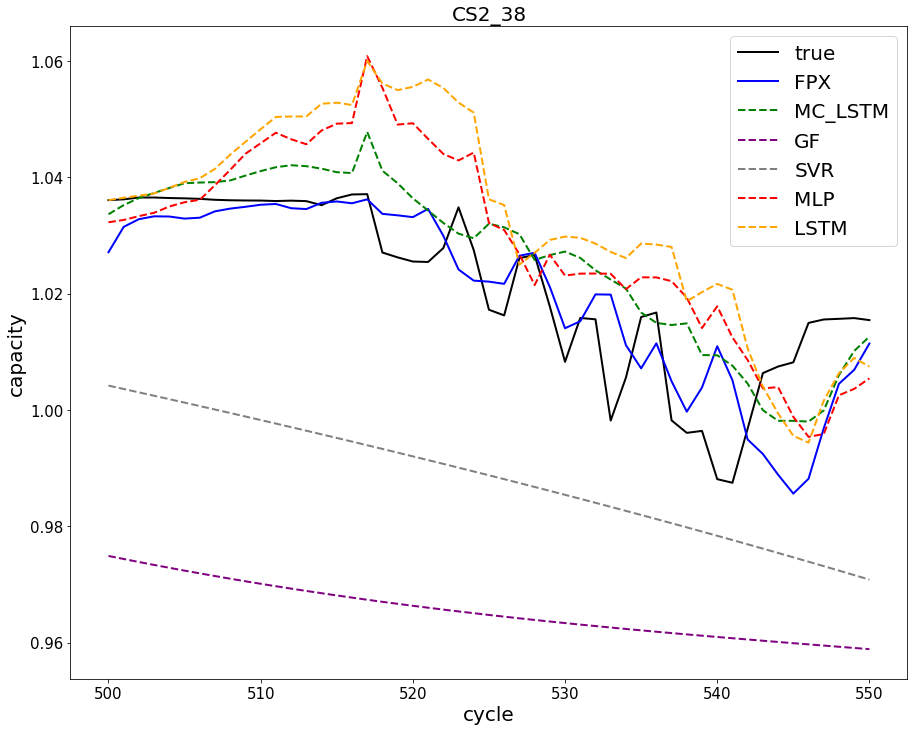

In [24]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in ['CS2_38']:
    sns.lineplot(data=df[bat].loc[500:550,'true'],linewidth=2,color='black',ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'FPX'],linewidth=2,color='blue',ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'MC_LSTM'],linewidth=2,color='g',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'GF'],linewidth=2,color='purple',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'SVR'],linewidth=2,color='gray',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'MLP'],linewidth=2,color='red',linestyle="--",ax=ax)
    sns.lineplot(data=df[bat].loc[500:550,'LSTM'],linewidth=2,color='orange',linestyle="--",ax=ax)
    ax.legend(['true','FPX','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax.set_xlabel('cycle',fontsize=20)
    ax.set_ylabel('capacity',fontsize=20)
    ax.set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
# plt.suptitle("Cycle 200-450",fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot()

[]

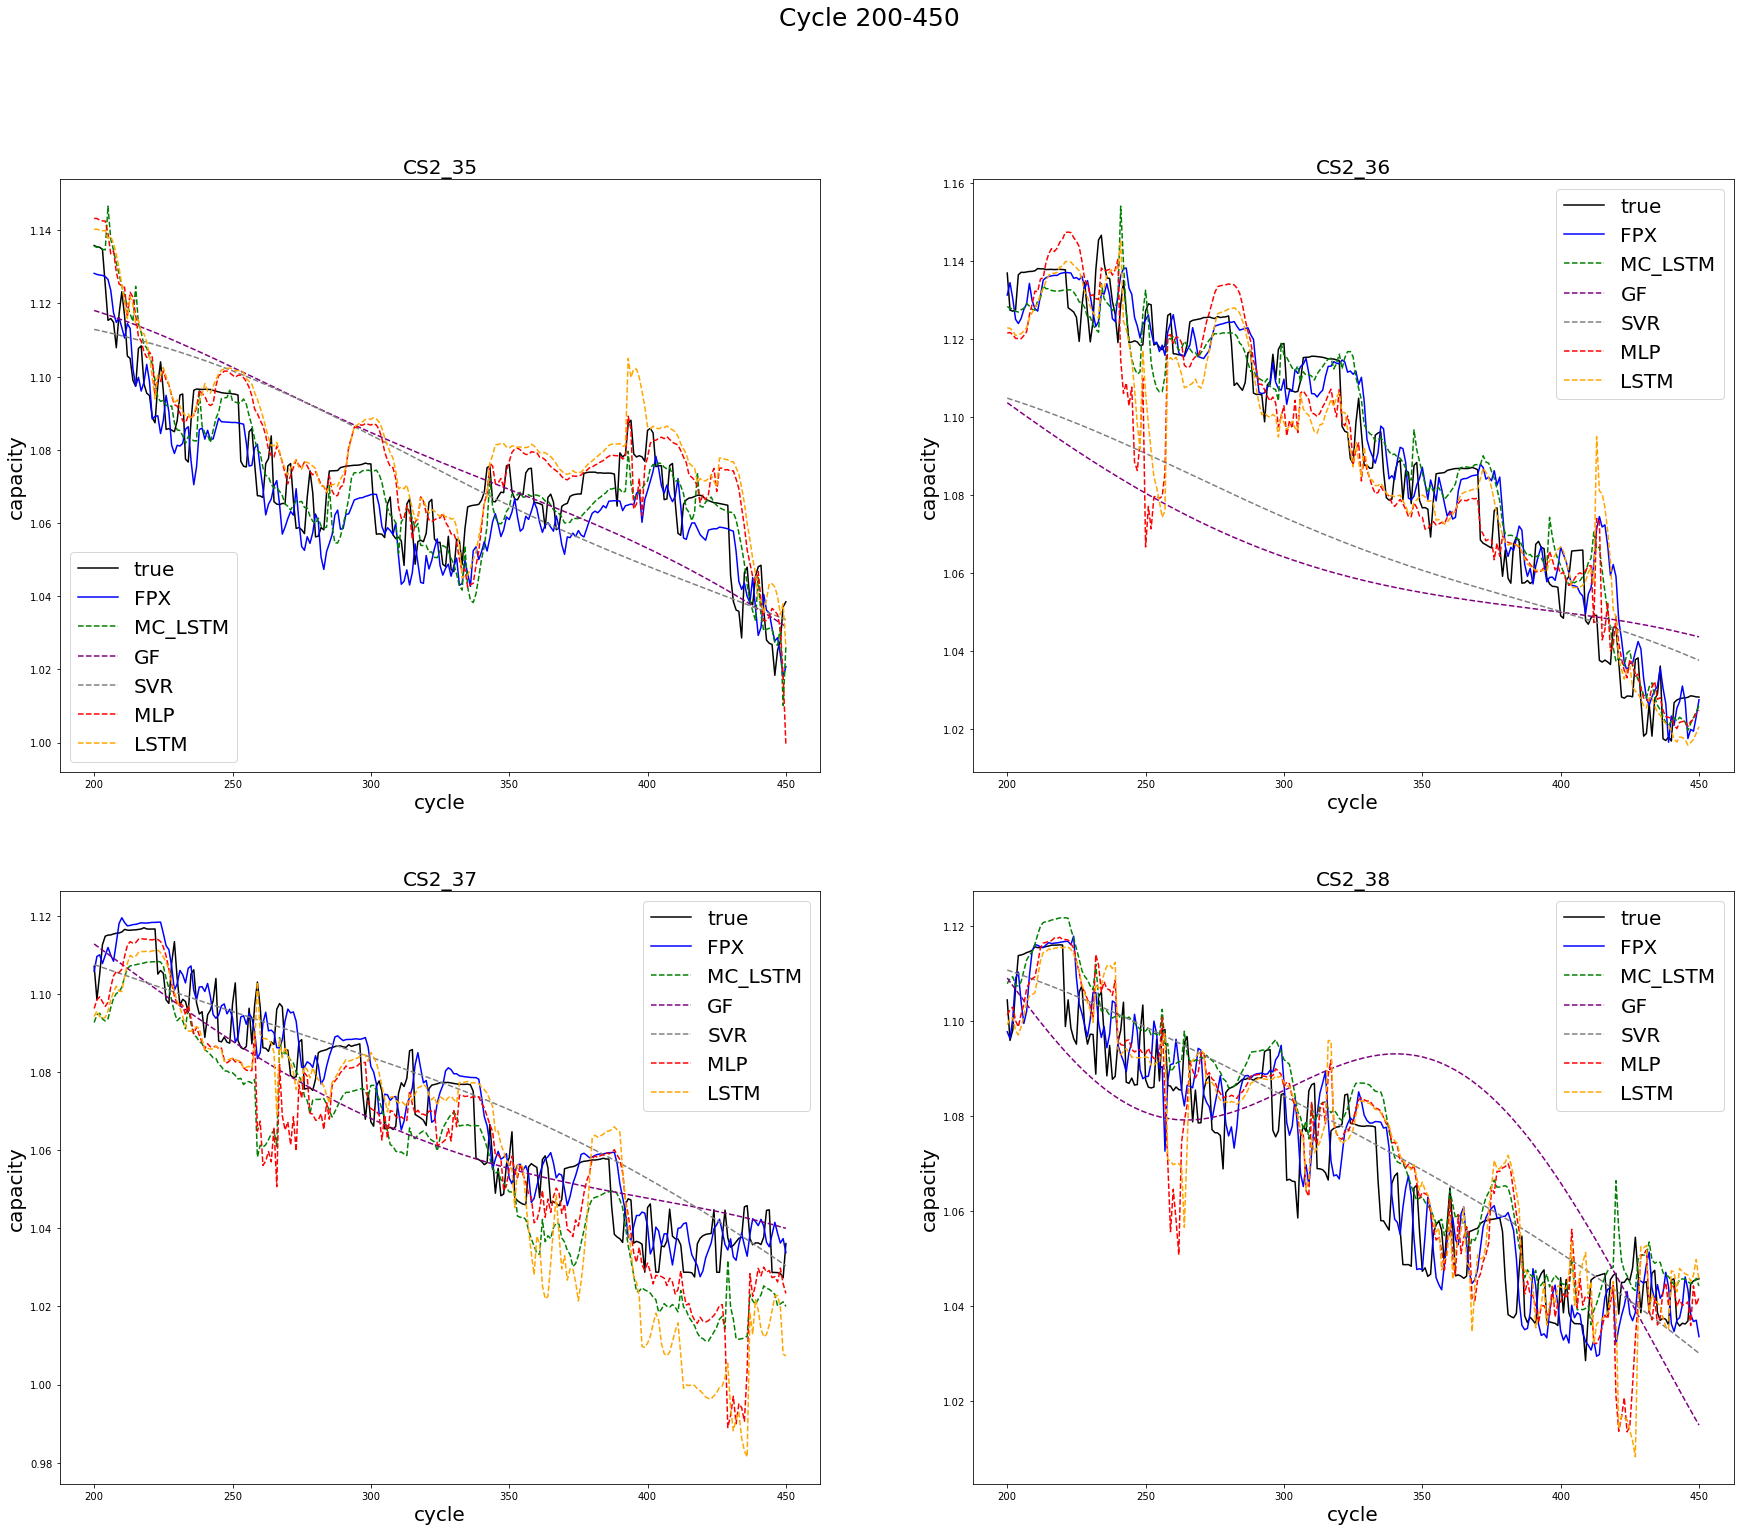

In [30]:
fig, ax = plt.subplots(2,2,figsize=(30,24))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in df:
    sns.lineplot(data=df[bat].loc[200:450,'true'],color='black',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[200:450,'FPX'],color='blue',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[200:450,'MC_LSTM'],color='g',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[200:450,'GF'],color='purple',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[200:450,'SVR'],color='gray',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[200:450,'MLP'],color='red',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[200:450,'LSTM'],color='orange',linestyle="--",ax=ax[i,j])
    ax[i,j].legend(['true','FPX','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax[i,j].set_xlabel('cycle',fontsize=20)
    ax[i,j].set_ylabel('capacity',fontsize=20)
    ax[i,j].set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
plt.suptitle("Cycle 200-450",fontsize=25)

plt.plot()

[]

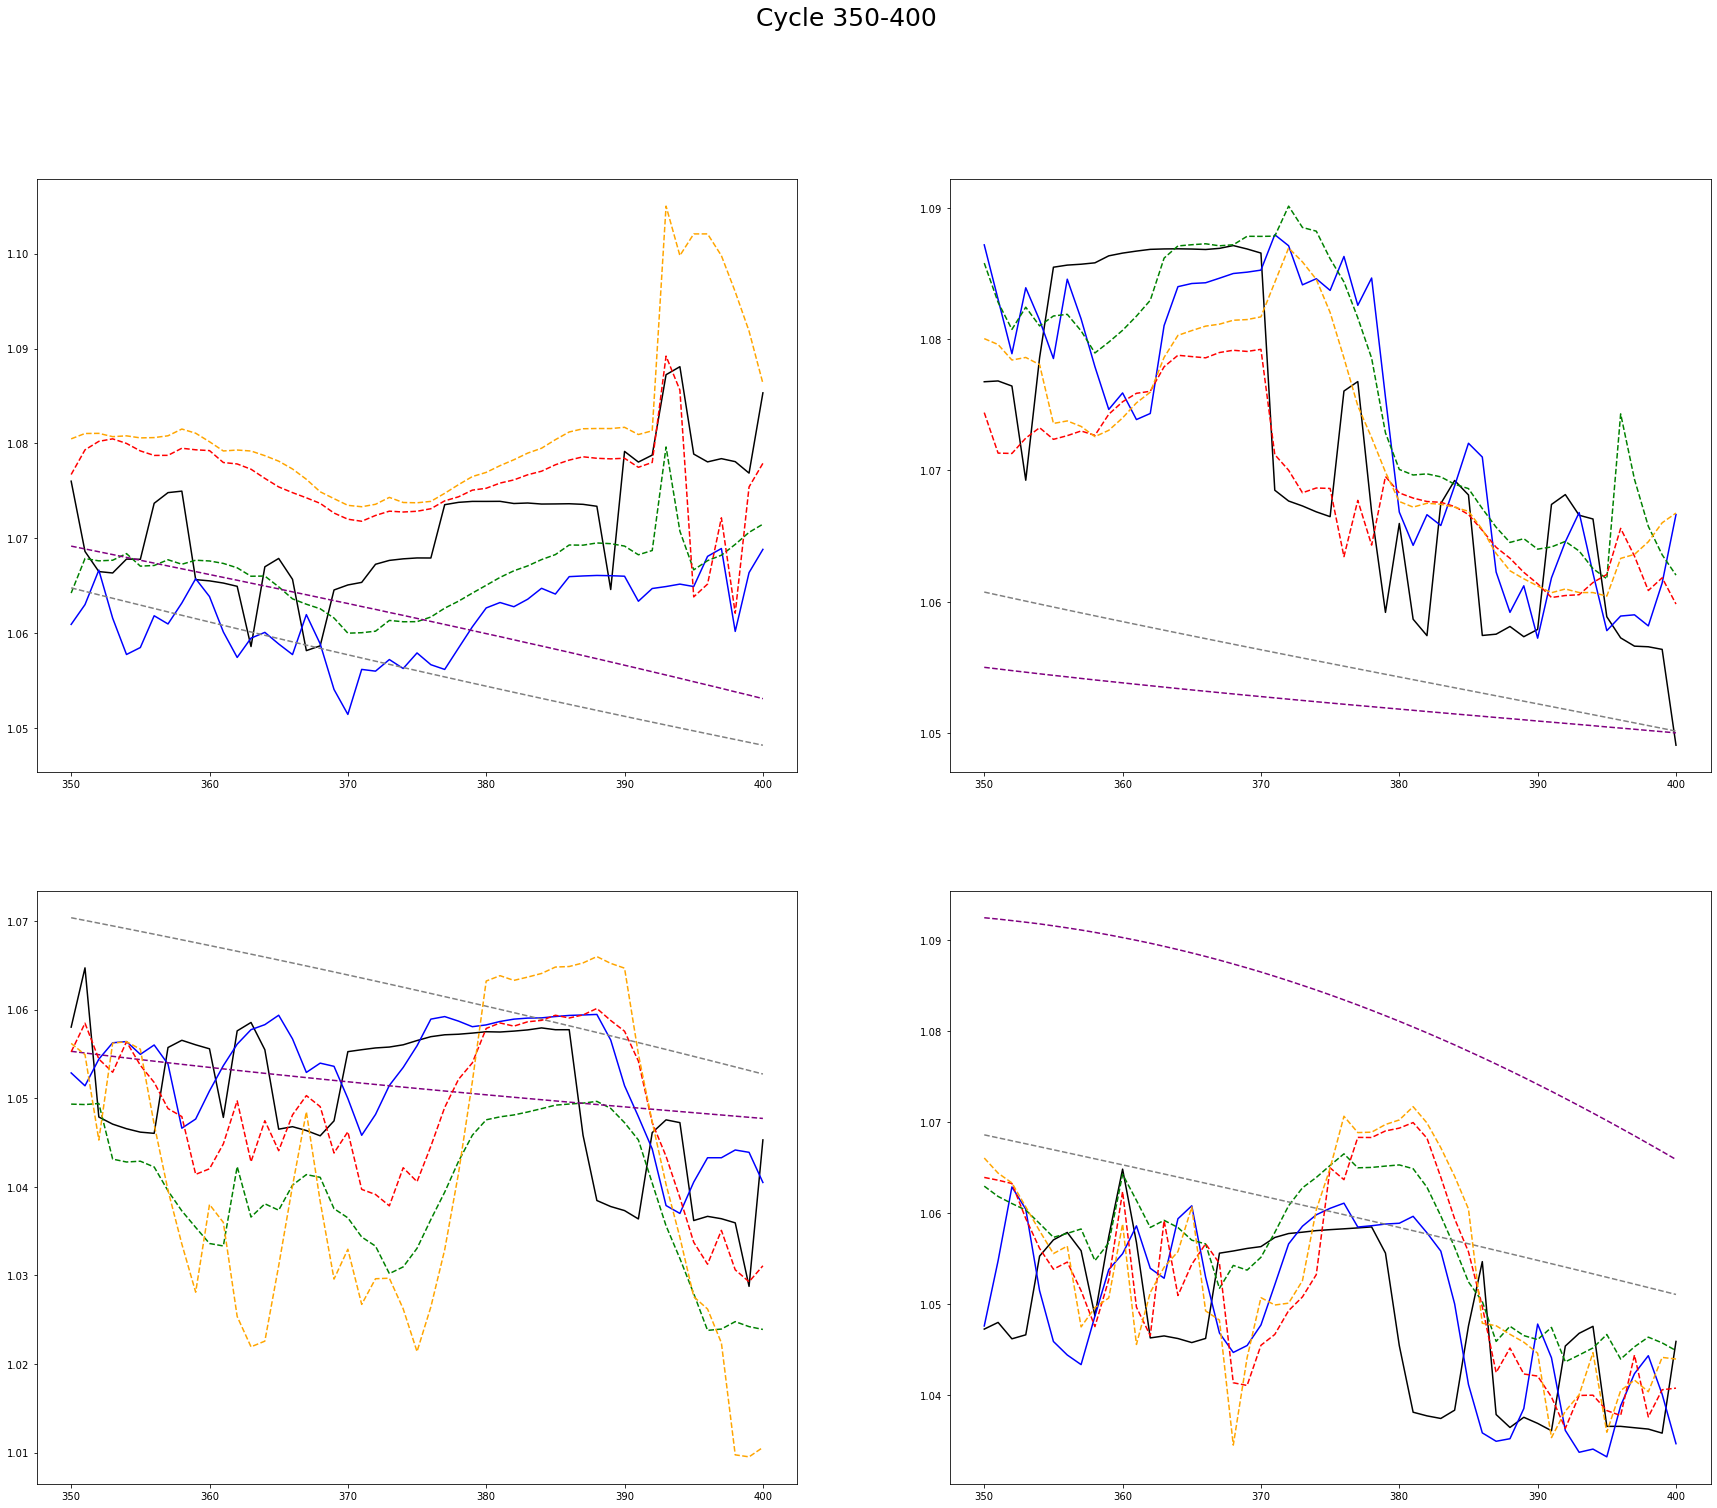

In [21]:
fig, ax = plt.subplots(2,2,figsize=(30,24))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in df:
    sns.lineplot(data=df[bat].loc[350:400,'true'],color='black',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[350:400,'FPX'],color='blue',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[350:400,'MC_LSTM'],color='g',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[350:400,'GF'],color='purple',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[350:400,'SVR'],color='gray',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[350:400,'MLP'],color='red',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[350:400,'LSTM'],color='orange',linestyle="--",ax=ax[i,j])
#     ax[i,j].legend(['true','FPX','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
#     ax[i,j].set_xlabel('cycle',fontsize=20)
    ax[i,j].set_ylabel(None)
#     ax[i,j].set_ylabel('capacity',fontsize=20)
#     ax[i,j].set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
plt.suptitle("Cycle 350-400",fontsize=25)

plt.plot()

[]

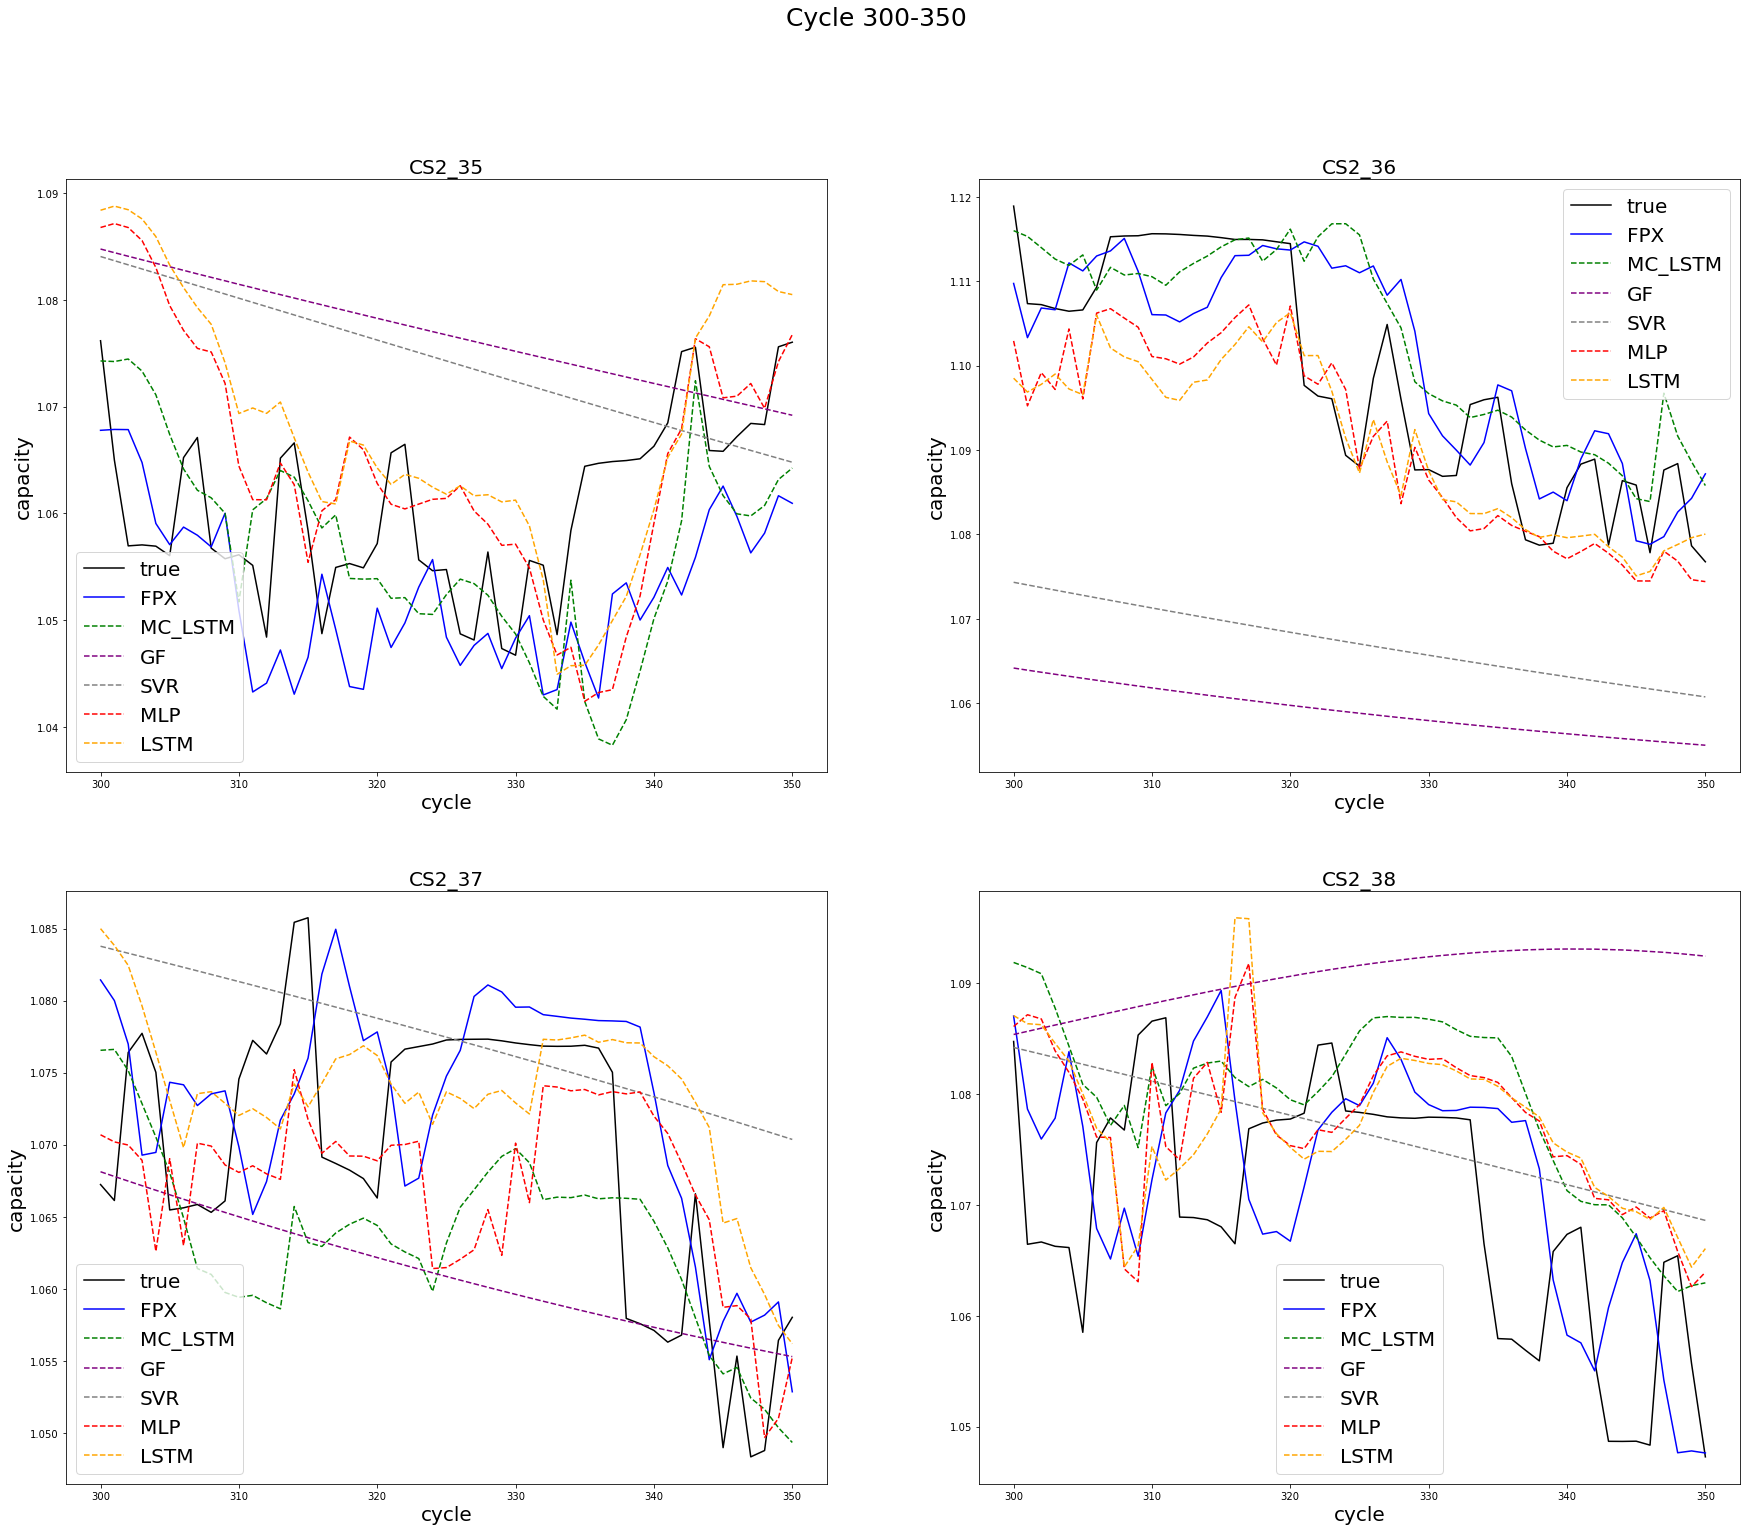

In [32]:
fig, ax = plt.subplots(2,2,figsize=(30,24))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in df:
    sns.lineplot(data=df[bat].loc[300:350,'true'],color='black',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[300:350,'FPX'],color='blue',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[300:350,'MC_LSTM'],color='g',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[300:350,'GF'],color='purple',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[300:350,'SVR'],color='gray',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[300:350,'MLP'],color='red',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[300:350,'LSTM'],color='orange',linestyle="--",ax=ax[i,j])
    ax[i,j].legend(['true','FPX','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax[i,j].set_xlabel('cycle',fontsize=20)
    ax[i,j].set_ylabel('capacity',fontsize=20)
    ax[i,j].set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
plt.suptitle("Cycle 300-350",fontsize=25)

plt.plot()

[]

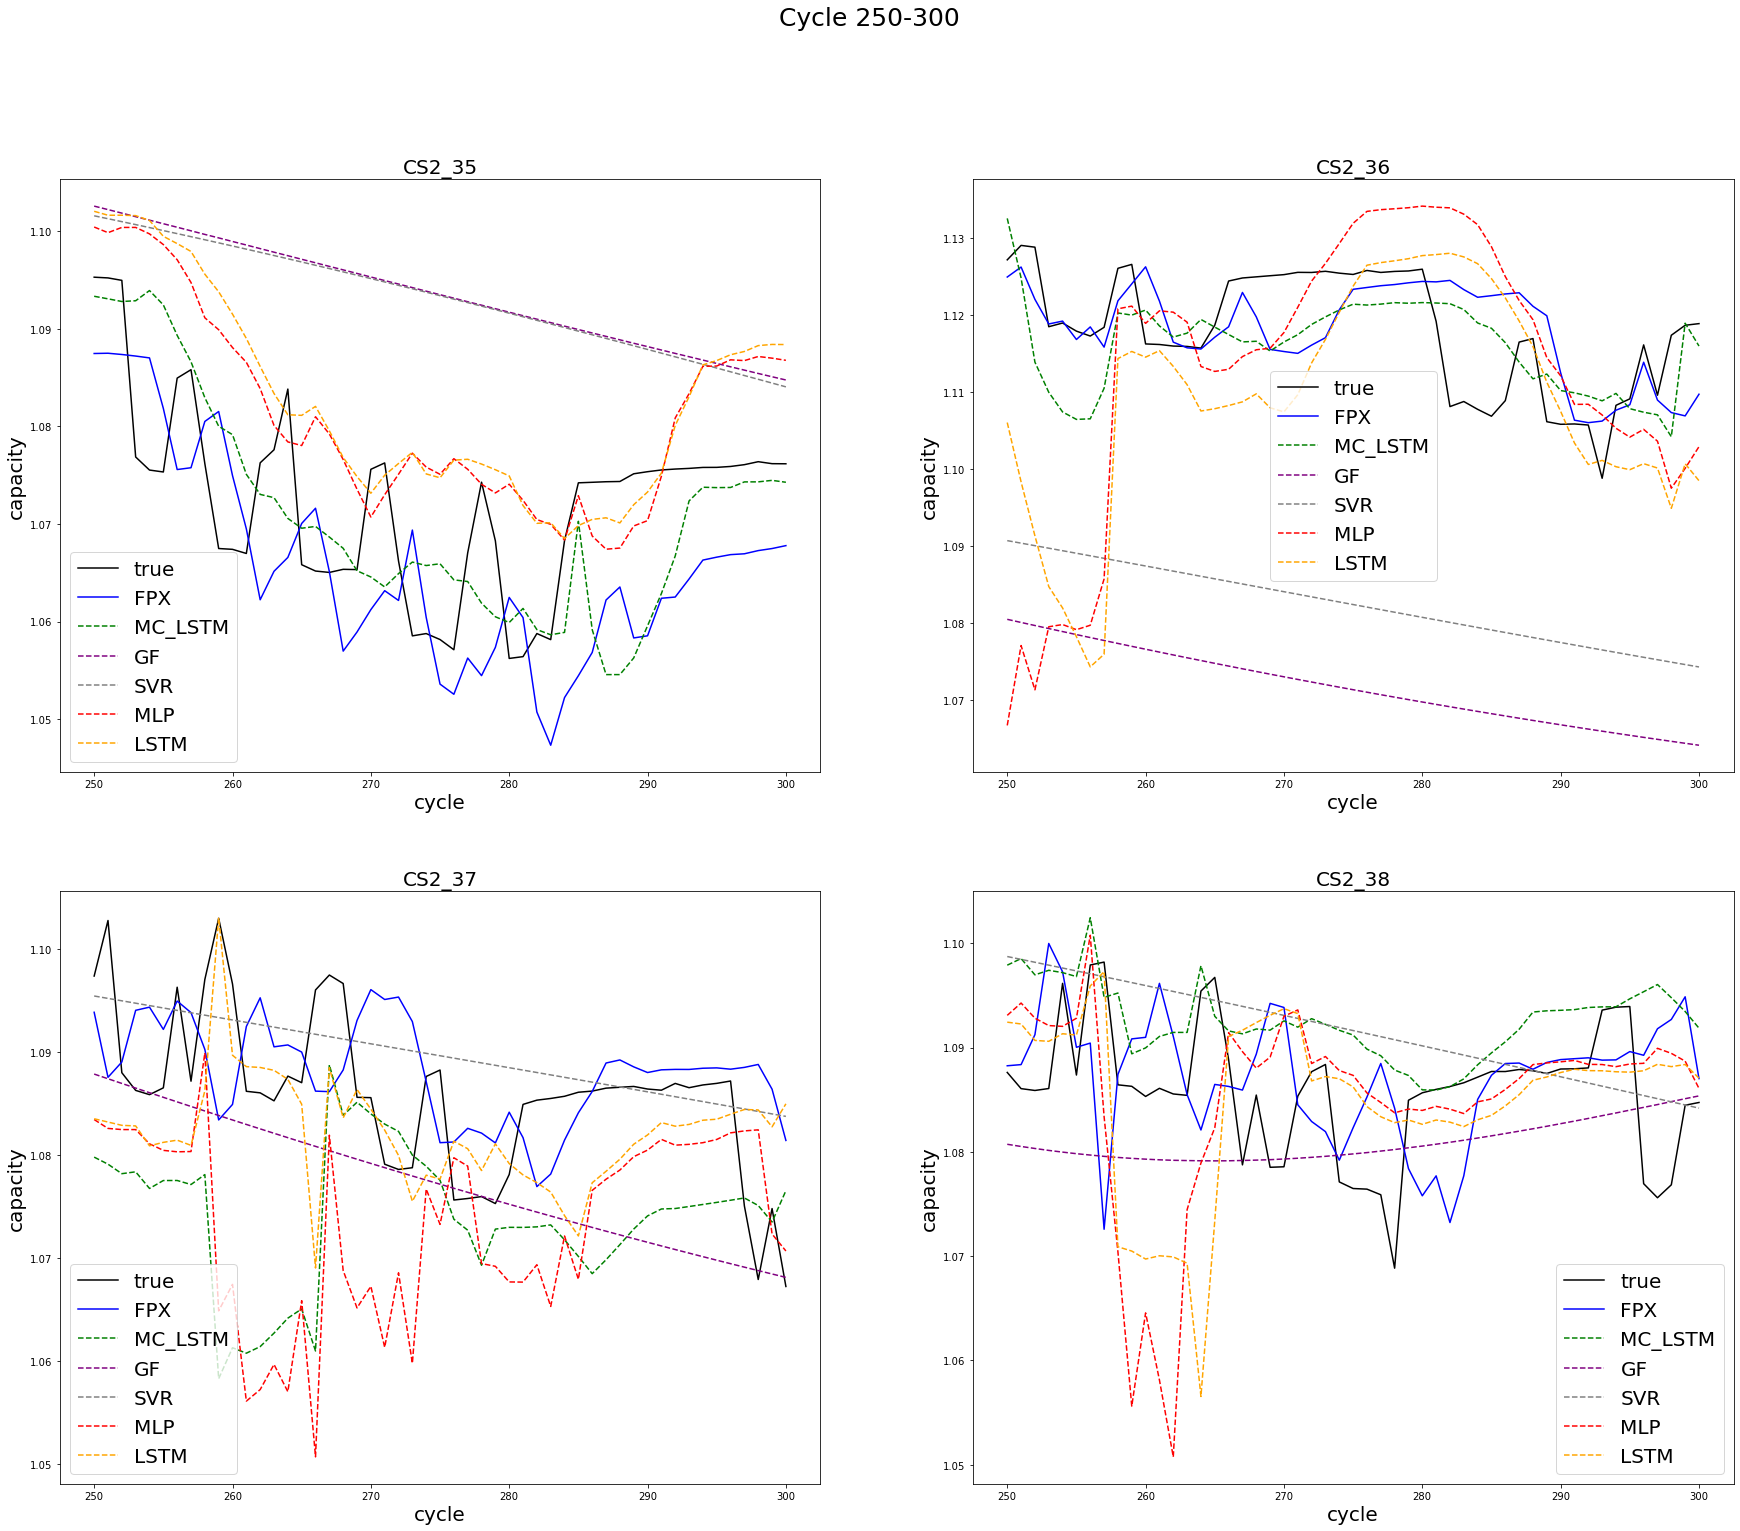

In [33]:
fig, ax = plt.subplots(2,2,figsize=(30,24))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in df:
    sns.lineplot(data=df[bat].loc[250:300,'true'],color='black',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[250:300,'FPX'],color='blue',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[250:300,'MC_LSTM'],color='g',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[250:300,'GF'],color='purple',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[250:300,'SVR'],color='gray',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[250:300,'MLP'],color='red',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[250:300,'LSTM'],color='orange',linestyle="--",ax=ax[i,j])
    ax[i,j].legend(['true','FPX','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax[i,j].set_xlabel('cycle',fontsize=20)
    ax[i,j].set_ylabel('capacity',fontsize=20)
    ax[i,j].set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
plt.suptitle("Cycle 250-300",fontsize=25)

plt.plot()

[]

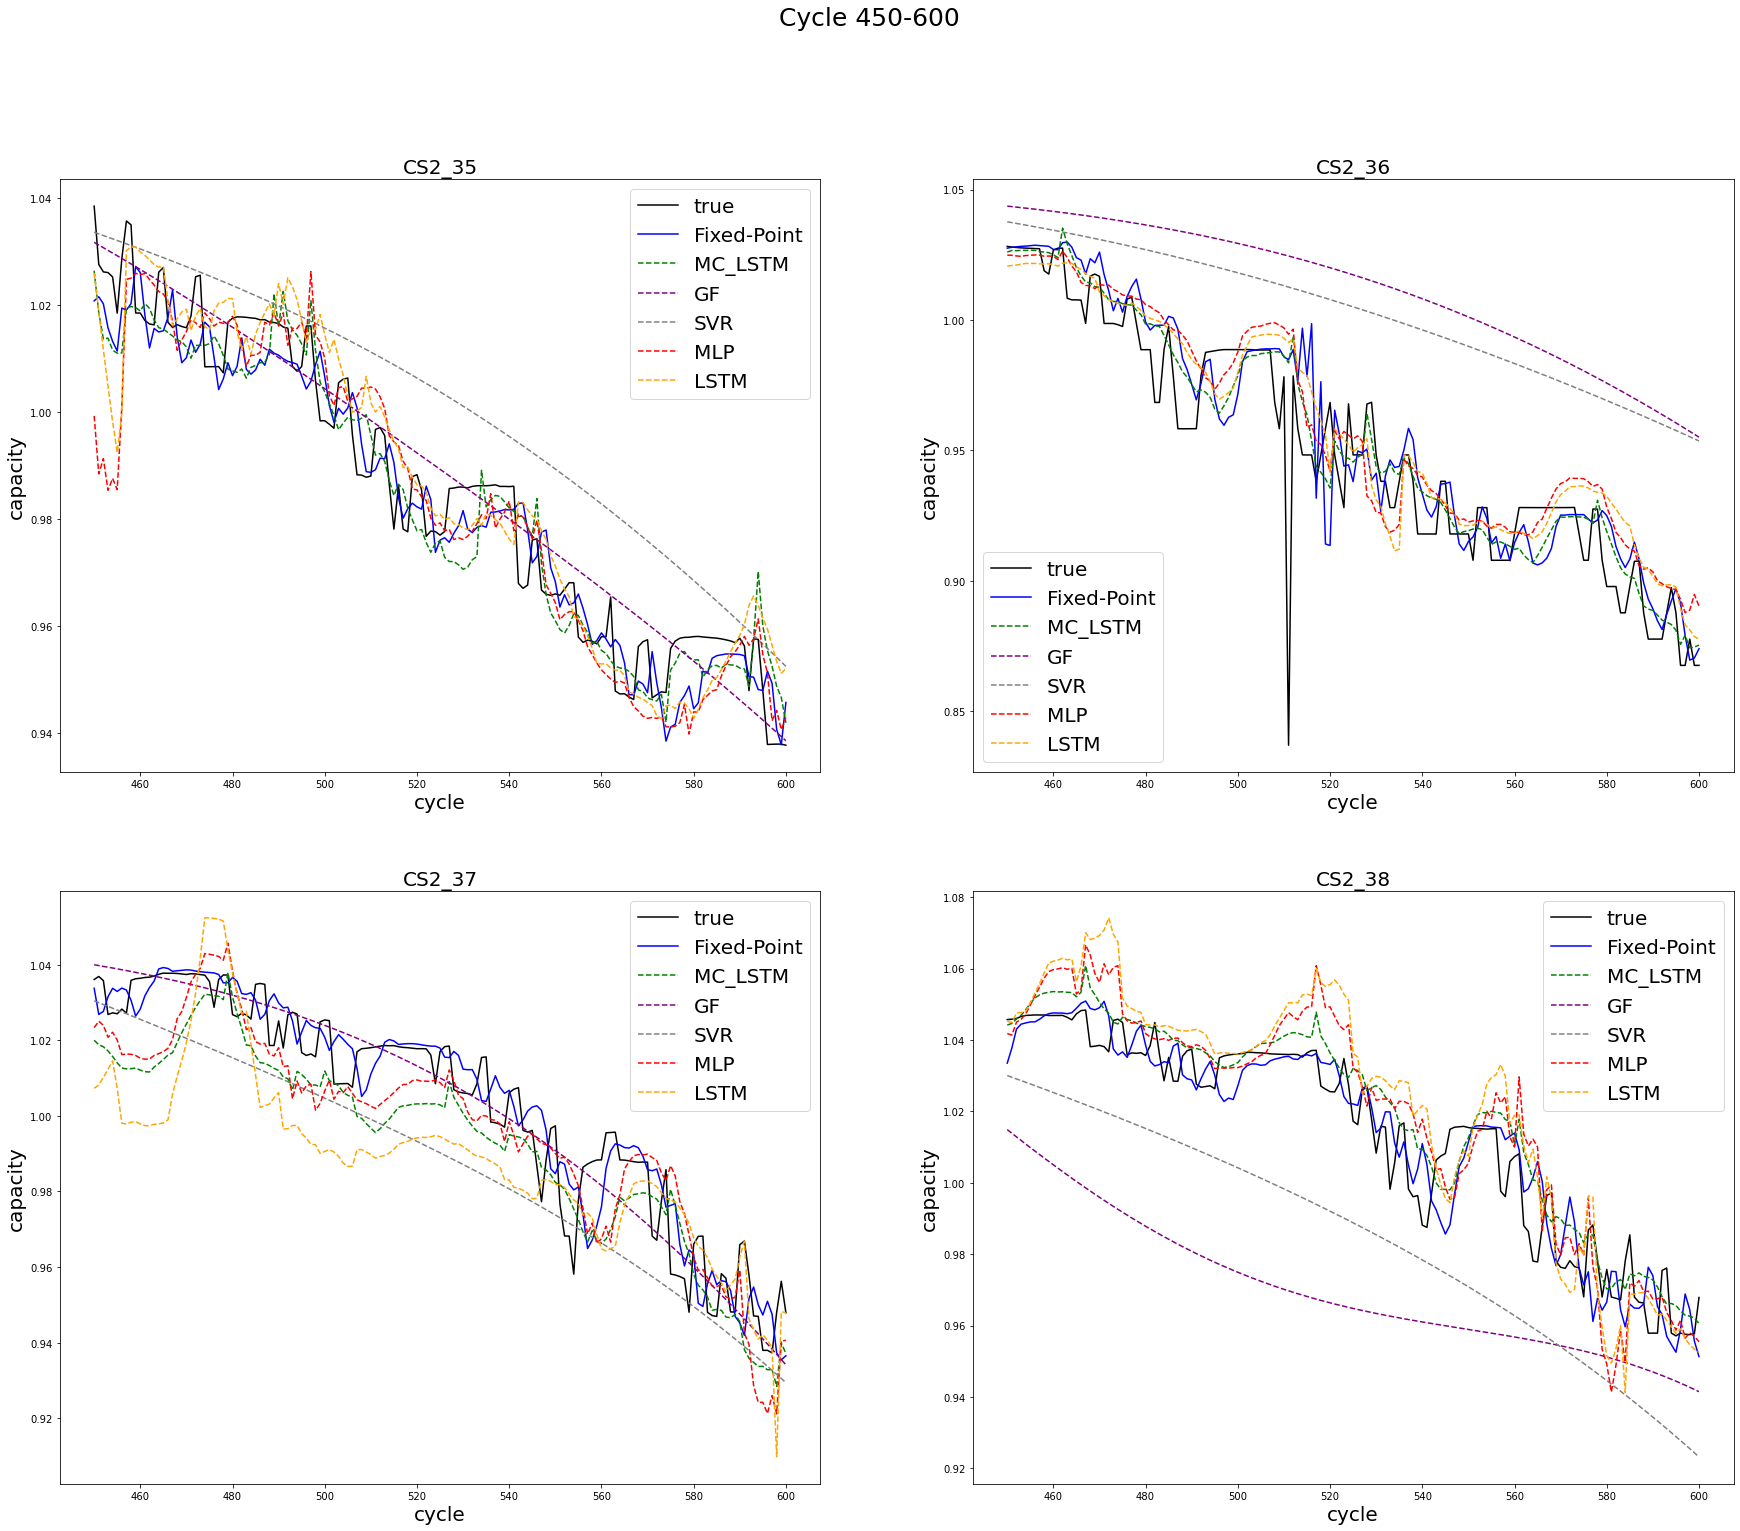

In [44]:
fig, ax = plt.subplots(2,2,figsize=(30,24))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in df:
    sns.lineplot(data=df[bat].loc[450:600,'true'],color='black',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[450:600,'FPX'],color='blue',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[450:600,'MC_LSTM'],color='g',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[450:600,'GF'],color='purple',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[450:600,'SVR'],color='gray',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[450:600,'MLP'],color='red',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[450:600,'LSTM'],color='orange',linestyle="--",ax=ax[i,j])
    ax[i,j].legend(['true','Fixed-Point','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax[i,j].set_xlabel('cycle',fontsize=20)
    ax[i,j].set_ylabel('capacity',fontsize=20)
    ax[i,j].set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
plt.suptitle("Cycle 450-600",fontsize=25)
plt.plot()

[]

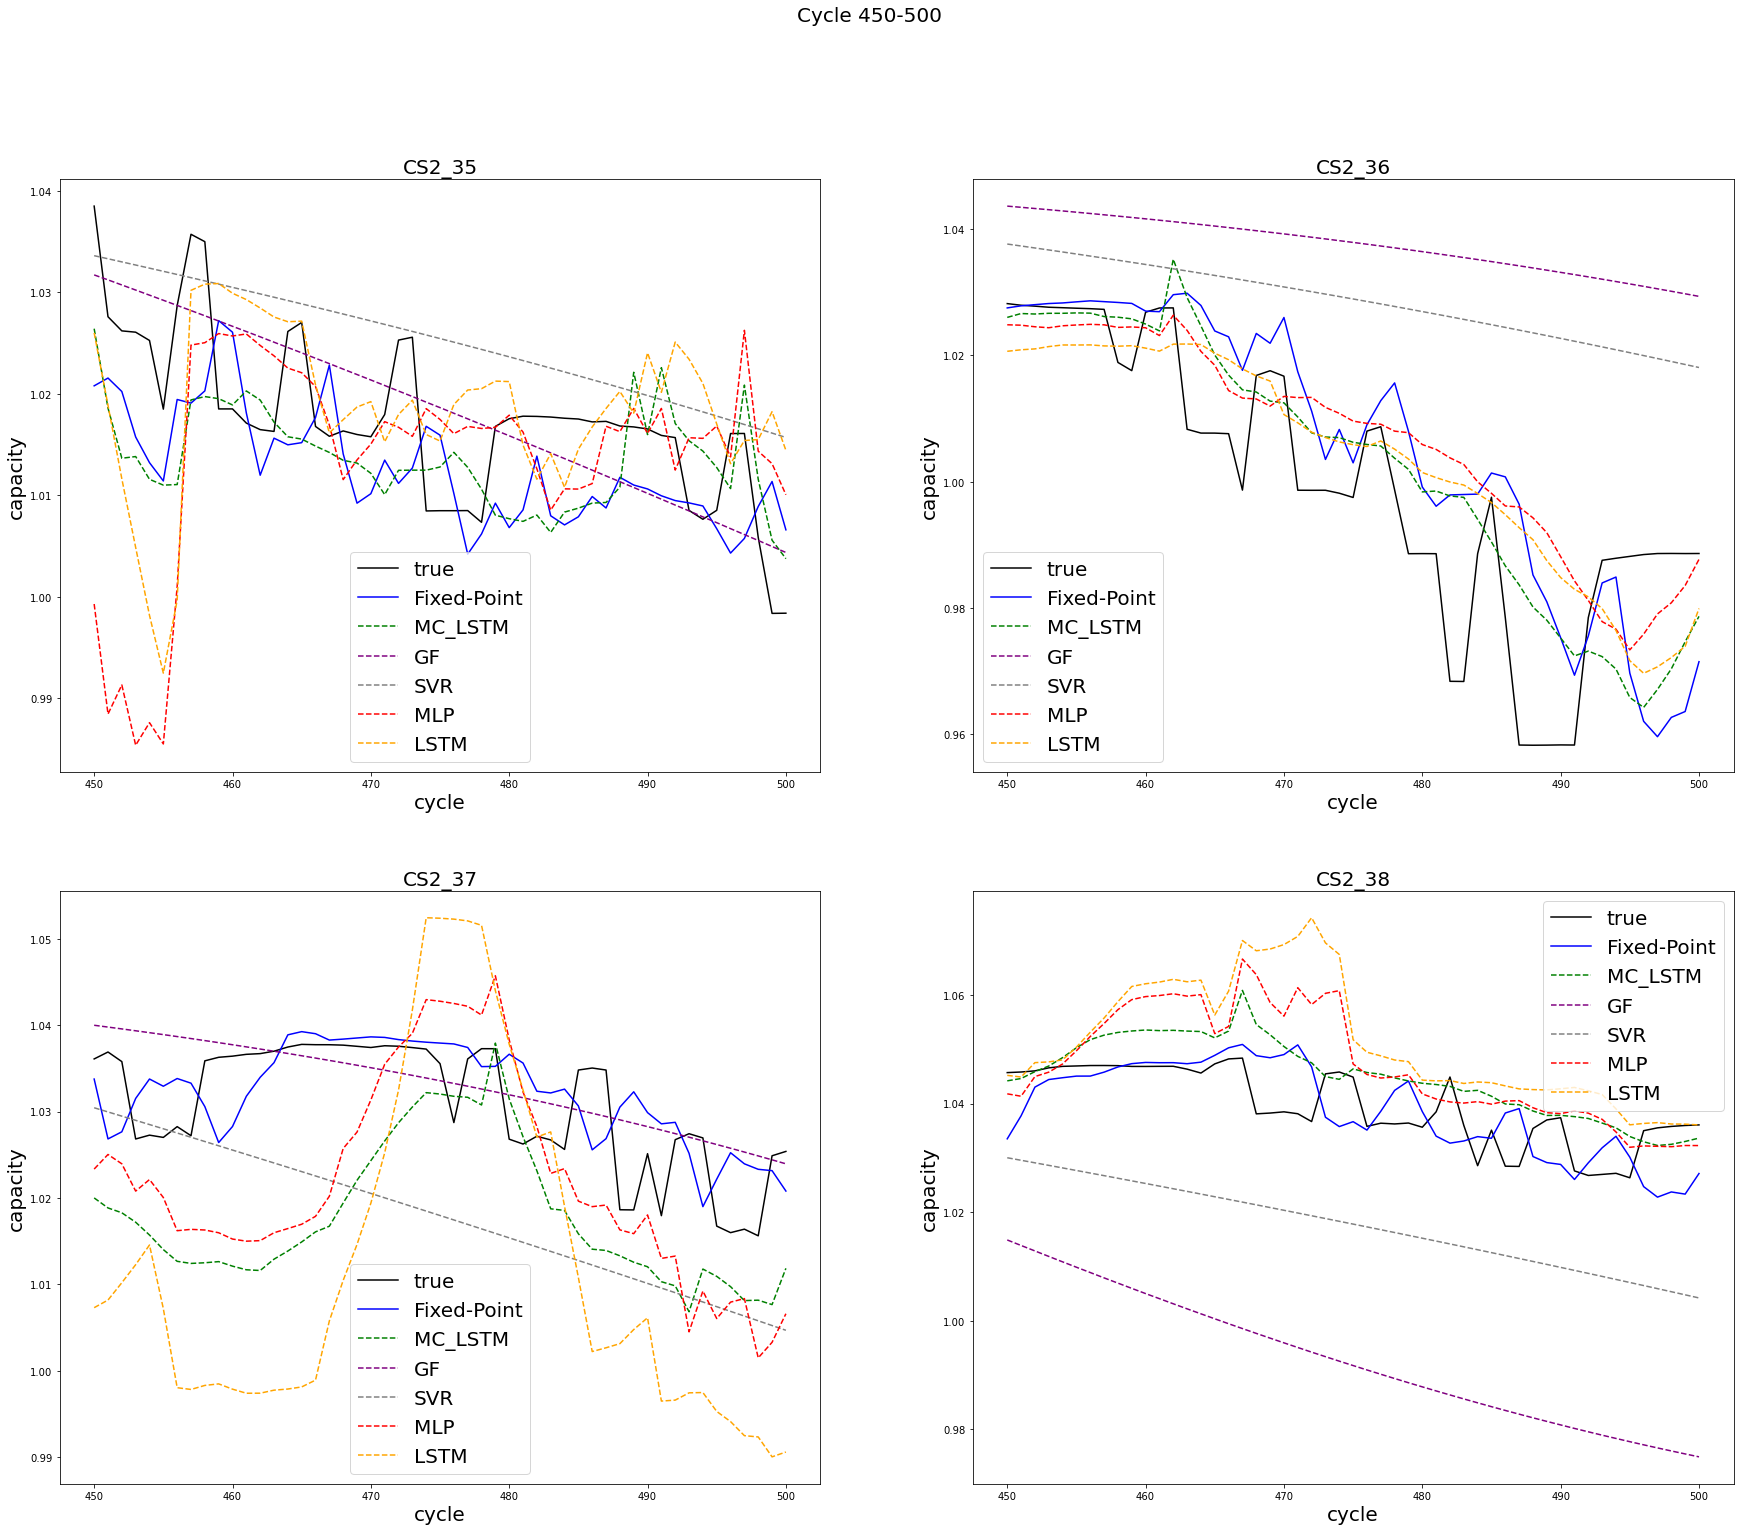

In [45]:
fig, ax = plt.subplots(2,2,figsize=(30,24))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in df:
    sns.lineplot(data=df[bat].loc[450:500,'true'],color='black',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[450:500,'FPX'],color='blue',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[450:500,'MC_LSTM'],color='g',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[450:500,'GF'],color='purple',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[450:500,'SVR'],color='gray',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[450:500,'MLP'],color='red',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[450:500,'LSTM'],color='orange',linestyle="--",ax=ax[i,j])
    ax[i,j].legend(['true','Fixed-Point','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax[i,j].set_xlabel('cycle',fontsize=20)
    ax[i,j].set_ylabel('capacity',fontsize=20)
    ax[i,j].set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
plt.suptitle("Cycle 450-500",fontsize=20)
plt.plot()

[]

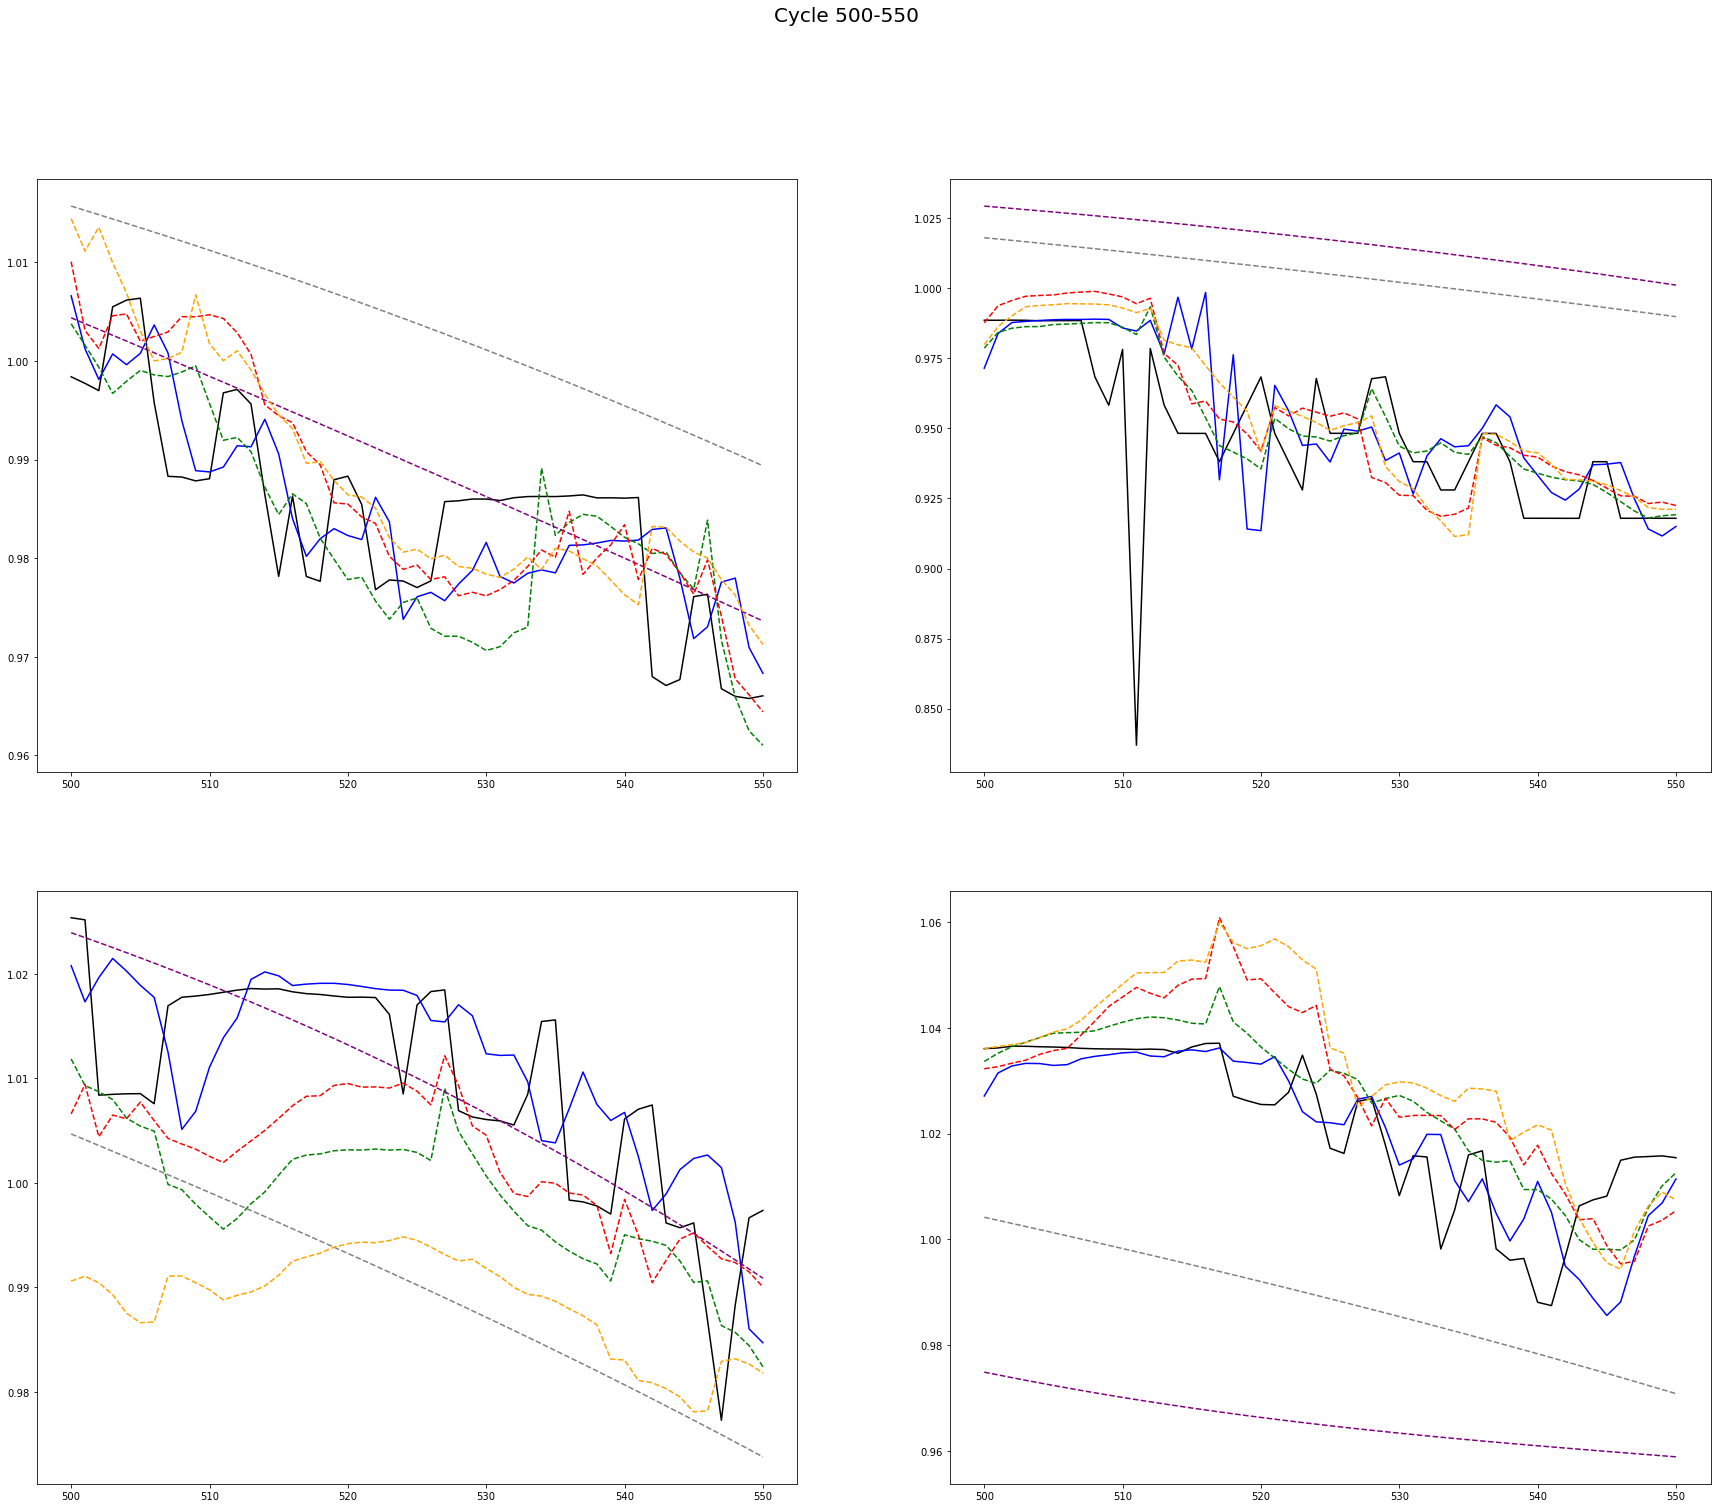

In [22]:
fig, ax = plt.subplots(2,2,figsize=(30,24))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in df:
    sns.lineplot(data=df[bat].loc[500:550,'true'],color='black',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[500:550,'FPX'],color='blue',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[500:550,'MC_LSTM'],color='g',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[500:550,'GF'],color='purple',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[500:550,'SVR'],color='gray',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[500:550,'MLP'],color='red',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[500:550,'LSTM'],color='orange',linestyle="--",ax=ax[i,j])
#     ax[i,j].legend(['true','Fixed-Point','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
#     ax[i,j].set_xlabel('cycle',fontsize=20)
#     ax[i,j].set_ylabel('capacity',fontsize=20)
#     ax[i,j].set_title(bat,fontsize=20)
    ax[i,j].set_ylabel(None)
    j += 1
    if j > 1:
        j = 0
        i += 1
plt.suptitle("Cycle 500-550",fontsize=20)
plt.plot()

[]

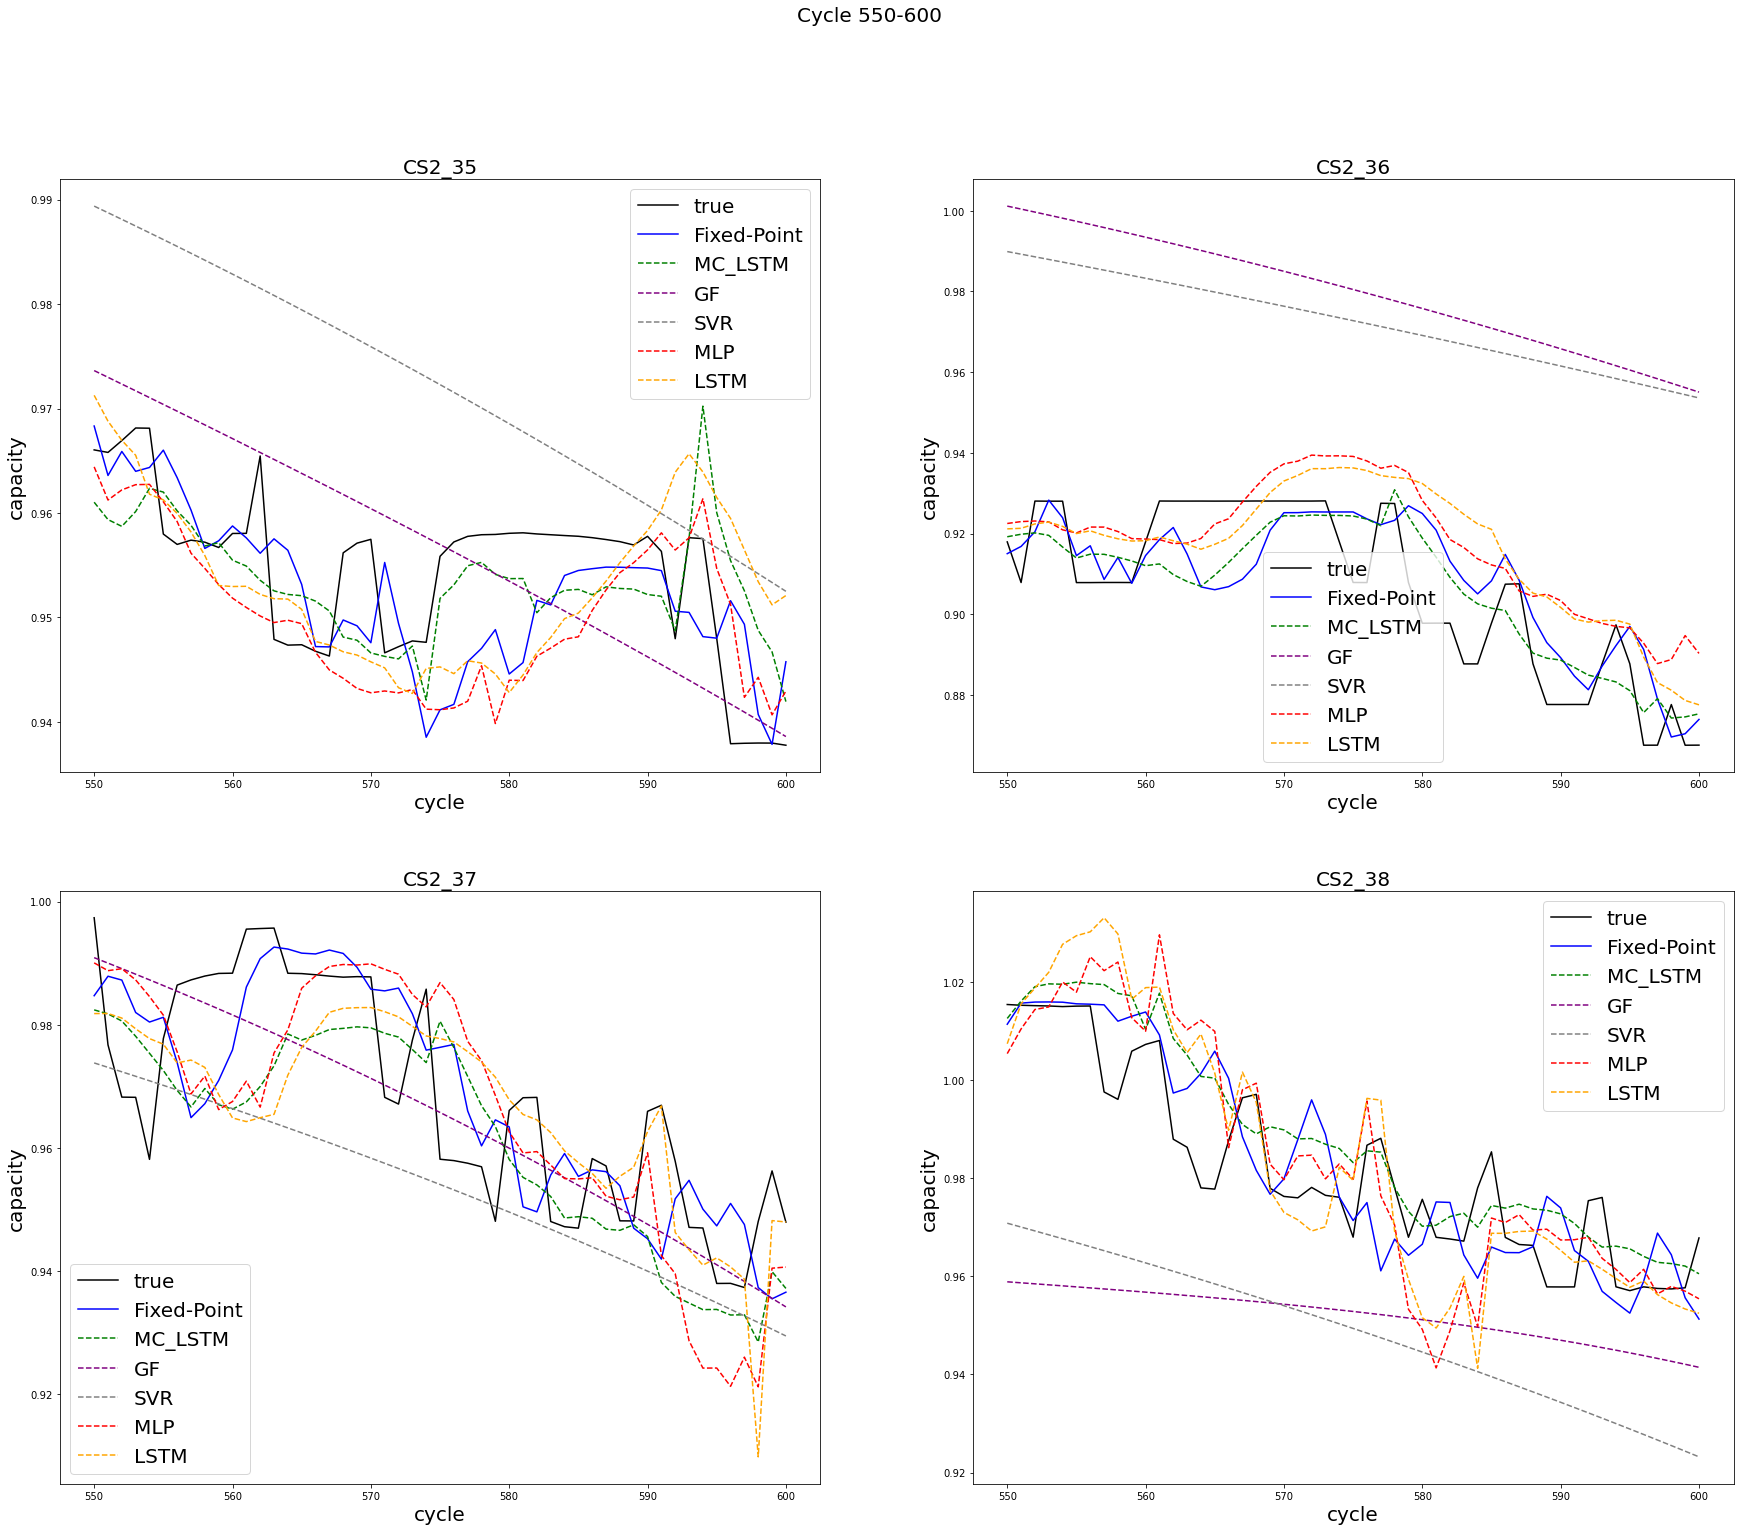

In [47]:
fig, ax = plt.subplots(2,2,figsize=(30,24))
# df['CS2_35'].rename(columns={'truth': 'true'}, inplace=True)
i,j=0,0
for bat in df:
    sns.lineplot(data=df[bat].loc[550:600,'true'],color='black',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[550:600,'FPX'],color='blue',ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[550:600,'MC_LSTM'],color='g',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[550:600,'GF'],color='purple',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[550:600,'SVR'],color='gray',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[550:600,'MLP'],color='red',linestyle="--",ax=ax[i,j])
    sns.lineplot(data=df[bat].loc[550:600,'LSTM'],color='orange',linestyle="--",ax=ax[i,j])
    ax[i,j].legend(['true','Fixed-Point','MC_LSTM','GF','SVR','MLP','LSTM'],fontsize=20)
    ax[i,j].set_xlabel('cycle',fontsize=20)
    ax[i,j].set_ylabel('capacity',fontsize=20)
    ax[i,j].set_title(bat,fontsize=20)
    j += 1
    if j > 1:
        j = 0
        i += 1
plt.suptitle("Cycle 550-600",fontsize=20)
plt.plot()